<a href="https://colab.research.google.com/github/Alex-Roberts27/JaxProjectData/blob/main/JAX_2026_PDDP_immune_Maya%2C_Alex_%26_Wimeth_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if 'gene_id' in corr_df.columns:
    corr_df = corr_df.drop('gene_id', axis=1)

# Calculate metric (variance, mean, etc.) on genes before dropping
# Assuming you want to filter genes (rows) by some metric
if 'gene_name' in corr_df.columns:
    # Set gene_name as index
    corr_df = corr_df.set_index('gene_name')

# Calculate variance for each gene (row)
gene_variances = corr_df.var(axis=1)  # axis=1 means across columns (samples)
sorted_genes = gene_variances.sort_values(ascending=True)  # Lowest variance first

print(f"Total genes: {len(sorted_genes)}")
print(f"\nLowest variance genes (first 10):")
print(sorted_genes.head(10))

# Drop the N genes with lowest variance
N = 51000
genes_to_drop = sorted_genes.index[:N]

# Check which genes actually exist
existing_genes = [g for g in genes_to_drop if g in corr_df.index]
missing_genes = [g for g in genes_to_drop if g not in corr_df.index]

print(f"\nGenes to drop: {N}")
print(f"Genes found in dataframe: {len(existing_genes)}")
print(f"Genes NOT found: {len(missing_genes)}")

if missing_genes:
    print(f"Missing genes (first 10): {missing_genes[:10]}")

# Drop only the genes that exist
dropped_df = corr_df.drop(index=existing_genes)  # Use index, not columns!

print(f"\nOriginal shape: {corr_df.shape}")
print(f"New shape: {dropped_df.shape}")
print(f"Genes remaining: {dropped_df.shape[0]}")

In [ ]:
!pip install geopandas
!pip install geopandas --upgrade
import geopandas as gpd

Cleaning our dataset to go from proteins to genes

In [ ]:
# typical Data Cleaning stack
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
import requests

In [ ]:
# FOR BLOOD
# Python package to add geneID to our data
import pandas as pd
import requests
import time
from typing import Dict, List

#removing invalid Ids
def clean_protein_ids(idlist: List[str]) -> List[str]:
    """Remove invalid IDs and get unique set"""
    valid_ids = []
    for uid in idlist:
        if uid and len(uid) >= 6 and uid[0].isalpha() and uid != 'heavy':
            valid_ids.append(uid)

    unique_ids = list(set(valid_ids))
    print(f"Cleaned: {len(idlist)} total -> {len(unique_ids)} unique valid IDs")
    return unique_ids

#query uniprot, ask for whole list, give accession numbers, gene ID, gene names
def map_uniprot_simple(idlist: List[str], batch_size: int = 50) -> Dict[str, str]:
    """
    Simplified mapper using direct UniProt entry retrieval.
    """
    mapping = {}
    unique_ids = clean_protein_ids(idlist)

    print(f"\nMapping {len(unique_ids)} unique UniProt IDs...")

    for i in range(0, len(unique_ids), batch_size):
        batch = unique_ids[i:i+batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(unique_ids) + batch_size - 1) // batch_size

        print(f"Processing batch {batch_num}/{total_batches} ({len(batch)} IDs)...")

        url = "https://rest.uniprot.org/uniprotkb/accessions"
        params = {
            'accessions': ','.join(batch),
            'format': 'json',
            'fields': 'accession,gene_primary'
        }

        try:
            response = requests.get(url, params=params, timeout=30)

            if response.status_code == 200:
                data = response.json()

                if 'results' in data:
                    for entry in data['results']:
                        accession = entry.get('primaryAccession')

                        gene_name = None
                        if 'genes' in entry and entry['genes']:
                            gene_info = entry['genes'][0]
                            if 'geneName' in gene_info:
                                gene_name = gene_info['geneName'].get('value')

                        if accession and gene_name:
                            mapping[accession] = gene_name

                print(f"  Mapped {len([b for b in batch if b in mapping])}/{len(batch)} from this batch")
            else:
                print(f"  Batch failed with status {response.status_code}")

            time.sleep(0.3)

        except Exception as e:
            print(f"  Error in batch {batch_num}: {e}")
            continue

    print(f"\nTotal mapped: {len(mapping)}/{len(unique_ids)}")
    return mapping

#dataframe map
def create_mapped_dataframe(df: pd.DataFrame,
                           protein_id_col: str = 'Protein_id',
                           score_col: str = 'MAPP_absoluteScore') -> pd.DataFrame:
    """Create a new dataframe with gene names added."""
    idlist = df[protein_id_col].tolist()
    gene_map = map_uniprot_simple(idlist)

    df = df.copy()
    df['Gene_Name'] = df[protein_id_col].map(gene_map) #take gene names we got from uniprot and add to dataframe

    total_rows = len(df)
    mapped_rows = df['Gene_Name'].notna().sum()
    unique_ids = df[protein_id_col].nunique()
    unique_mapped = df[df['Gene_Name'].notna()][protein_id_col].nunique()

    print(f"\n=== Mapping Summary ===")
    print(f"Total rows: {total_rows}")
    print(f"Rows with gene names: {mapped_rows} ({mapped_rows/total_rows*100:.1f}%)")
    print(f"Unique protein IDs: {unique_ids}")
    print(f"Unique IDs mapped: {unique_mapped} ({unique_mapped/unique_ids*100:.1f}%)")

    unmapped_unique = df[df['Gene_Name'].isna()][protein_id_col].unique()
    if len(unmapped_unique) > 0:
        print(f"\nUnmapped unique IDs ({len(unmapped_unique)}): {list(unmapped_unique[:20])}")

    return df


# NOW RUN THIS:
pddp = pd.read_table("bloodprotein_names.txt")
print("Original data:")
print(pddp.head())

# Create mapped dataframe
df_with_genes = create_mapped_dataframe(pddp)

# Check results
print("\n\nFirst 20 rows with gene names:")
print(df_with_genes.head(20))

print("\n\nSample of unique mappings:")
print(df_with_genes[['Protein_id', 'Gene_Name','MAPP_absoluteScore']].drop_duplicates().head(30))

#perm. unique
# df_unique = df_with_genes.drop_duplicates(subset=["Gene_Name", "MAPP_absoluteScore"], keep="first")
df_unique = df_with_genes.drop_duplicates(subset=["Gene_Name"], keep="first")

df_unique.to_csv("bloodprotein_with_genes.csv", index=False)
print("\n✓ Saved to bloodprotein_with_genes.csv")

goi = df_unique[['Gene_Name']]
print (goi)

#MAPP score above 5:
#filtering MAPP scores above 5 df_unique
filtered_df_unique = df_unique[df_unique['MAPP_absoluteScore'] >= 5]
filtered_df_unique.to_csv("5bloodprotein_with_genes.csv", index=False)
print("\n✓ Saved to bloodprotein_with_genes.csv")

Original data:
            Blood                                    MAPP  MAPP_absoluteScore  \
0       QQLYWSHPR  GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNMC            7.499082   
1       QQLYWSHPR   GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNM            7.460637   
2       QQLYWSHPR     GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGL            7.310881   
3       QQLYWSHPR       GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKY            6.856005   
4  GKVKVGVNGFGRIG                  GKVKVGVNGFGRIGRLVTRAAF            6.367344   

  Protein_id  
0     P62273  
1     P62273  
2     P62273  
3     P62273  
4     P04406  
Cleaned: 4875 total -> 154 unique valid IDs

Mapping 154 unique UniProt IDs...
Processing batch 1/4 (50 IDs)...
  Mapped 50/50 from this batch
Processing batch 2/4 (50 IDs)...
  Mapped 48/50 from this batch
Processing batch 3/4 (50 IDs)...
  Mapped 50/50 from this batch
Processing batch 4/4 (4 IDs)...
  Mapped 4/4 from this batch

Total mapped: 152/154

=== Mapping Summary ===
Total rows: 4875
Rows with g

In [ ]:
# FOR A549 (same as above, just. few names changed)

import pandas as pd
import requests
import time
from typing import Dict, List

def clean_protein_ids(idlist: List[str]) -> List[str]:
    """Remove invalid IDs and get unique set"""
    valid_ids = []
    for uid in idlist:
        # Skip if empty, too short, doesn't start with letter, or is a decoy
        if (uid and
            len(uid) >= 6 and
            uid[0].isalpha() and
            uid != 'heavy' and
            not uid.startswith('REV__') and  # Filter out reverse decoys
            not uid.startswith('CON__')):    # Filter out contaminants
            valid_ids.append(uid)

    unique_ids = list(set(valid_ids))
    print(f"Cleaned: {len(idlist)} total -> {len(unique_ids)} unique valid IDs")
    return unique_ids

def map_uniprot_simple(idlist: List[str], batch_size: int = 50) -> Dict[str, str]:
    """
    Map UniProt IDs to gene names using the search endpoint.
    """
    mapping = {}
    unique_ids = clean_protein_ids(idlist)

    print(f"\nMapping {len(unique_ids)} unique UniProt IDs...")

    for i in range(0, len(unique_ids), batch_size):
        batch = unique_ids[i:i+batch_size]
        batch_num = i // batch_size + 1
        total_batches = (len(unique_ids) + batch_size - 1) // batch_size

        print(f"\nProcessing batch {batch_num}/{total_batches} ({len(batch)} IDs)...")

        # Use search endpoint with proper query format
        url = "https://rest.uniprot.org/uniprotkb/search"

        # Build query string for multiple accessions
        query = ' OR '.join([f'accession:{acc}' for acc in batch])

        params = {
            'query': query,
            'format': 'json',
            'fields': 'accession,gene_primary,gene_names',
            'size': batch_size
        }

        try:
            response = requests.get(url, params=params, timeout=30)

            if response.status_code == 200:
                data = response.json()

                if 'results' in data:
                    for entry in data['results']:
                        accession = entry.get('primaryAccession')

                        gene_name = None

                        # Method 1: Try genes array
                        if 'genes' in entry and entry['genes']:
                            gene_info = entry['genes'][0]
                            if 'geneName' in gene_info:
                                gene_name = gene_info['geneName'].get('value')

                        if accession and gene_name:
                            mapping[accession] = gene_name
                            print(f"  ✓ {accession} -> {gene_name}")

                mapped_in_batch = len([b for b in batch if b in mapping])
                print(f"  Mapped {mapped_in_batch}/{len(batch)} from this batch")
            else:
                print(f"  ⚠ Batch failed with status {response.status_code}")
                print(f"  Response: {response.text[:300]}")

            time.sleep(0.5)  # Be nice to the API

        except Exception as e:
            print(f"  ⚠ Error in batch {batch_num}: {e}")
            continue

    print(f"\n{'='*50}")
    print(f"Total mapped: {len(mapping)}/{len(unique_ids)}")
    print(f"{'='*50}")
    return mapping

def create_mapped_dataframe(df: pd.DataFrame,
                           protein_id_col: str = 'Protein_id',
                           score_col: str = 'MAPP_absoluteScore') -> pd.DataFrame:
    """Create a new dataframe with gene names added."""
    print(f"\nStarting mapping for column: {protein_id_col}")

    idlist = df[protein_id_col].tolist()
    gene_map = map_uniprot_simple(idlist)

    df = df.copy()
    df['Gene_Name'] = df[protein_id_col].map(gene_map)

    total_rows = len(df)
    mapped_rows = df['Gene_Name'].notna().sum()
    unique_ids = df[protein_id_col].nunique()
    unique_mapped = df[df['Gene_Name'].notna()][protein_id_col].nunique()

    print(f"\n{'='*50}")
    print(f"MAPPING SUMMARY")
    print(f"{'='*50}")
    print(f"Total rows: {total_rows}")
    print(f"Rows with gene names: {mapped_rows} ({mapped_rows/total_rows*100:.1f}%)")
    print(f"Unique protein IDs: {unique_ids}")
    print(f"Unique IDs mapped: {unique_mapped} ({unique_mapped/unique_ids*100:.1f}%)")

    unmapped_unique = df[df['Gene_Name'].isna()][protein_id_col].unique()
    if len(unmapped_unique) > 0:
        print(f"\nUnmapped unique IDs ({len(unmapped_unique)}):")
        print(list(unmapped_unique[:20]))

    return df


# MAIN EXECUTION
if __name__ == "__main__":
    print("Loading data...")
    pddp = pd.read_table("A549protein_names.txt")

    print("\nOriginal data:")
    print(pddp.head())
    print(f"\nShape: {pddp.shape}")
    print(f"Columns: {pddp.columns.tolist()}")

    # Check for decoy/contaminant entries
    decoy_count = pddp['Protein_id'].str.startswith('REV__').sum()
    contam_count = pddp['Protein_id'].str.startswith('CON__').sum()
    print(f"\nDecoy entries (REV__): {decoy_count}")
    print(f"Contaminant entries (CON__): {contam_count}")

    # Create mapped dataframe
    df_with_genes = create_mapped_dataframe(pddp)

    # Show results
    print("\n" + "="*50)
    print("RESULTS - First 20 rows")
    print("="*50)
    print(df_with_genes[['Protein_id', 'Gene_Name', 'MAPP_absoluteScore']].head(20))

    print("\n" + "="*50)
    print("UNIQUE MAPPINGS - Sample")
    print("="*50)
    print(df_with_genes[['Protein_id', 'Gene_Name', 'MAPP_absoluteScore']]
          .drop_duplicates(subset=['Protein_id'])
          .head(30))

    # Remove duplicates based on Gene_Name
    df_unique = df_with_genes.drop_duplicates(subset=["Gene_Name"], keep="first")

    # Save to CSV
    df_unique.to_csv("A549protein_with_genes.csv", index=False)
    print(f"\n✓ Saved {len(df_unique)} unique genes to A549protein_with_genes.csv")

    # Show gene names only
    goi = df_unique[['Gene_Name']].dropna()
    print(f"\nGenes of interest (first 20):")
    print(goi.head(20))

    #MAPP score above 5:
    #filtering MAPP scores above 5 df_unique
    filtered_df_unique = df_unique[df_unique['MAPP_absoluteScore'] >= 5]
    filtered_df_unique.to_csv("5bloodprotein_with_genes.csv", index=False)
    print("\n✓ Saved to bloodprotein_with_genes.csv")



Loading data...

Original data:
      A549_secretome                                    MAPP  \
0        GHQQLYWSHPR  GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNMC   
1  GHQQLYWSHPRKFGQGS  GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNMC   
2        GHQQLYWSHPR   GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNM   
3  GHQQLYWSHPRKFGQGS   GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGLNM   
4        GHQQLYWSHPR     GHQQLYWSHPRKFGQGSRSCRVCSNRHGLIRKYGL   

   MAPP_absoluteScore Protein_id  
0            7.499082     P62273  
1            7.499082     P62273  
2            7.460637     P62273  
3            7.460637     P62273  
4            7.310881     P62273  

Shape: (3122, 4)
Columns: ['A549_secretome', 'MAPP', 'MAPP_absoluteScore', 'Protein_id']

Decoy entries (REV__): 5
Contaminant entries (CON__): 0

Starting mapping for column: Protein_id
Cleaned: 3122 total -> 134 unique valid IDs

Mapping 134 unique UniProt IDs...

Processing batch 1/3 (50 IDs)...
  ✓ O95139 -> NDUFB6
  ✓ P05204 -> HMGN2
  ✓ P08670 -> VIM
  ✓ P10619 ->


**DATA** **WRANGLING**

In [ ]:
#reading in bone dataset
control_1 = pd.read_excel("GSM5073659_Ctrl1_3D.xlsx")
control_2 = pd.read_excel("GSM5073660_Ctrl2_3D.xlsx")
control_3 = pd.read_excel("GSM5073661_Ctrl3_3D.xlsx")
control_4 = pd.read_excel("GSM5073665_Ctrl1_14D.xlsx")
control_5 = pd.read_excel("GSM5073666_Ctrl2_14D.xlsx")
control_6 = pd.read_excel("GSM5073667_Ctrl3_14D.xlsx")

infected_1 = pd.read_excel("GSM5073662_IAOM1_3D.xlsx")
infected_2 = pd.read_excel("GSM5073663_IAOM2_3D.xlsx")
infected_3 = pd.read_excel("GSM5073664_IAOM3_3D.xlsx")
infected_4 = pd.read_excel("GSM5073668_IAOM1_14D.xlsx")
infected_5 = pd.read_excel("GSM5073669_IAOM2_14D.xlsx")
infected_6 = pd.read_excel("GSM5073670_IAOM3_14D.xlsx")


In [ ]:
#combine all bone data into one dataframe:
#we're using fpkm, remove counts
#new data frame: for gene_name & fpkm


dfs = [control_1, control_2, control_3,
      control_4, control_5, control_6,
      infected_1, infected_2, infected_3,
      infected_4, infected_5, infected_6]

merged_df = dfs[0]

for df in dfs[1:]:
  merged_df = merged_df.merge(
      df,
      on = ["gene_id", "gene_name"],
      how = "inner"
  )
print(type(merged_df))



#renaming columns


merged_df = merged_df.rename(columns = {
    "Con1_3D_count": "Ctrl_BM1_count",
    "Con1_3D_fpkm": "Ctrl_BM1_fpkm",
    "Con2_3D_count": "Ctrl_BM2_count",
    "Con2_3D_fpkm": "Ctrl_BM2_fpkm",
    "Con3_3D_count": "Ctrl_BM3_count",
    "Con3_3D_fpkm": "Ctrl_BM3_fpkm",
    "Con1_14D_count": "Ctrl_BM4_count",
    "Con1_14D_fpkm": "Ctrl_BM4_fpkm",
    "Con2_14D_count":"Ctrl_BM5_count",
    "Con2_14D_fpkm":"Ctrl_BM5_fpkm",
    "Con3_14D_count":"Ctrl_BM6_count",
    "Con3_14D_fpkm":"Ctrl_BM6_fpkm",
    "Inf1_3D_count": "Inf_BM1_count",
    "Inf1_3D_fpkm": "Inf_BM1_fpkm",
    "Inf2_3D_count": "Inf_BM2_count",
    "Inf2_3D_fpkm": "Inf_BM2_fpkm",
    "Inf3_3D_count": "Inf_BM3_count",
    "Inf3_3D_fpkm": "Inf_BM3_fpkm",
    "Inf1_14D_count": "Inf_BM4_count",
    "Inf1_14D_fpkm": "Inf_BM4_fpkm",
    "Inf2_14D_count": "Inf_BM5_count",
    "Inf2_14D_fpkm": "Inf_BM5_fpkm",
    "Inf3_14D_count": "Inf_BM6_count",
    "Inf3_14D_fpkm": "Inf_BM6_fpkm"


})


barplot_df = merged_df


merged_df = merged_df.loc[:, ~merged_df.columns.str.contains("gene_name")]
merged_df = merged_df.set_index("gene_id")



merged_df.head()


<class 'pandas.core.frame.DataFrame'>


,Ctrl_BM1_count,Ctrl_BM1_fpkm,Ctrl_BM2_count,Ctrl_BM2_fpkm,Ctrl_BM3_count,Ctrl_BM3_fpkm,Ctrl_BM4_count,Ctrl_BM4_fpkm,Ctrl_BM5_count,Ctrl_BM5_fpkm,...,Inf_BM2_count,Inf_BM2_fpkm,Inf_BM3_count,Inf_BM3_fpkm,Inf_BM4_count,Inf_BM4_fpkm,Inf_BM5_count,Inf_BM5_fpkm,Inf_BM6_count,Inf_BM6_fpkm
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000056071,162642,17337.041178,214016,22942.990774,169850,18292.978420,154461,16656.975474,172891,18108.632026,...,183549,16383.297157,184734,16422.147542,246357,25933.736248,167028,17578.099432,221064,24290.859853
ENSMUSG00000064351,135839,4892.251438,124116,4495.454203,118699,4319.246105,127324,4639.055809,127137,4499.116471,...,154269,4652.324180,161513,4851.015015,151601,5391.930281,182144,6476.487399,147408,5472.527308
ENSMUSG00000032484,131047,5967.173355,156639,7173.035607,127052,5845.204014,114701,5283.768792,121980,5457.593485,...,120445,4592.375156,146654,5568.988559,169631,7627.894929,106341,4780.602926,151392,7106.030837
ENSMUSG00000056054,127175,10196.592266,147815,11918.821837,119135,9650.932376,99379,8060.889336,120108,9462.289373,...,131392,8821.231947,117080,7828.469465,179141,14184.244525,118500,9380.198283,152016,12563.921019
ENSMUSG00000069516,100193,4236.373755,114564,4871.543334,96148,4107.463750,80542,3445.199119,91608,3805.934177,...,109387,3872.840499,106339,3749.646284,154086,6433.954388,104237,4351.301268,127101,5539.728052


In [ ]:
#blood2 = pd.read_table("GSE127813_Whole_blood_gene_expression_matrix(1).txt")
#print(blood2)
# print(blood2.shape)
# print(blood2.columns)
# print(blood2.r)

DeSeq/VOLCANO

In [ ]:
!pip install pydeseq2
!pip install matplotlib scikit-learn pandas
import os
import pickle as pkl
import numpy as np

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data


SAVE = True


#if SAVE:
 # Replace this with the path to directory where you would like results to be
 # saved
 # OUTPUT_PATH = "../output_files/synthetic_example"
 # os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
#volcano plot input manipulation
volcano_df = merged_df.loc[:, ~merged_df.columns.str.contains("fpkm")]
volcano_df.head()
#switching columns and rows
volcano_df_switched = volcano_df.transpose()
volcano_df_switched.head(5)






gene_id,ENSMUSG00000056071,ENSMUSG00000064351,ENSMUSG00000032484,ENSMUSG00000056054,ENSMUSG00000069516,ENSMUSG00000037742,ENSMUSG00000032496,ENSMUSG00000069919,ENSMUSG00000029661,ENSMUSG00000001506,...,ENSMUSG00000096776,ENSMUSG00000096244,ENSMUSG00000095019,ENSMUSG00000094915,ENSMUSG00000084520,ENSMUSG00000099278,ENSMUSG00000095434,ENSMUSG00000094431,ENSMUSG00000098647,ENSMUSG00000096730
Ctrl_BM1_count,162642,135839,131047,127175,100193,113438,82491,102220,68039,63533,...,0,0,0,0,0,0,0,0,0,0
Ctrl_BM2_count,214016,124116,156639,147815,114564,105553,96262,98996,60277,56394,...,0,0,0,0,0,0,0,0,0,0
Ctrl_BM3_count,169850,118699,127052,119135,96148,104237,81879,105341,99775,93664,...,0,0,0,0,0,0,0,0,0,0
Ctrl_BM4_count,154461,127324,114701,99379,80542,100281,66467,121978,52321,43705,...,0,0,0,0,0,0,0,0,0,0
Ctrl_BM5_count,172891,127137,121980,120108,91608,106036,71887,128666,51132,42216,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#getting rid of 0 values
if 'gene_id' in volcano_df.columns:
    volcano_df_switched = volcano_df.drop('gene_id', axis=1)


# Calculate variance for each gene (row)
gene_variances = volcano_df.var(axis=1)  # axis=1 means across columns (samples)
sorted_genes = gene_variances.sort_values(ascending=True)  # Lowest variance first

print(f"Total genes: {len(sorted_genes)}")
print(f"\nLowest variance genes (first 10):")
print(sorted_genes.head(10))

# Drop the N genes with lowest variance
N = 51000
genes_to_drop = sorted_genes.index[:N]

# Check which genes actually exist
existing_genes = [g for g in genes_to_drop if g in volcano_df.index]
missing_genes = [g for g in genes_to_drop if g not in volcano_df.index]

print(f"\nGenes to drop: {N}")
print(f"Genes found in dataframe: {len(existing_genes)}")
print(f"Genes NOT found: {len(missing_genes)}")

if missing_genes:
    print(f"Missing genes (first 10): {missing_genes[:10]}")

# Drop only the genes that exist
dropped_df = volcano_df.drop(index=existing_genes)  # Use index, not columns!

print(f"\nOriginal shape: {volcano_df.shape}")
print(f"New shape: {volcano_df.shape}")
print(f"Genes remaining: {volcano_df.shape[0]}")

Total genes: 54532

Lowest variance genes (first 10):
gene_id
ENSMUSG00000106694    0.0
ENSMUSG00000105172    0.0
ENSMUSG00000088123    0.0
ENSMUSG00000106097    0.0
ENSMUSG00000105271    0.0
ENSMUSG00000106522    0.0
ENSMUSG00000104681    0.0
ENSMUSG00000093413    0.0
ENSMUSG00000052014    0.0
ENSMUSG00000106849    0.0
dtype: float64

Genes to drop: 51000
Genes found in dataframe: 51000
Genes NOT found: 0

Original shape: (54532, 12)
New shape: (54532, 12)
Genes remaining: 54532


In [ ]:
#metadata df
#volcano_df_switched = volcano_df_switched[volcano_df_switched.sum(axis = 1) > 0]
volcano_df_switched.head()

#metadata
metadata_df = pd.DataFrame(zip(volcano_df_switched.index, ["healthy", "healthy", "healthy",
                                                        "healthy", "healthy", "healthy",
                                                        "infected", "infected", "infected",
                                                        "infected", "infected", "infected"]),
                        columns = ["Sample", "Condition"])

metadata_df = metadata_df.set_index("Sample")

metadata_df.head(10)



,Condition
Sample,
Ctrl_BM1_count,healthy
Ctrl_BM2_count,healthy
Ctrl_BM3_count,healthy
Ctrl_BM4_count,healthy
Ctrl_BM5_count,healthy
Ctrl_BM6_count,healthy
Inf_BM1_count,infected
Inf_BM2_count,infected
Inf_BM3_count,infected


In [ ]:
#deSeq
dds = DeseqDataSet(counts = volcano_df_switched,
             metadata=metadata_df,
             design_factors = "Condition")

dds.deseq2()


Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipython-input-2784352532.py:2: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(counts = volcano_df_switched,
Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 38.25 seconds.

Fitting dispersion trend curve...
... done in 1.34 seconds.

Fitting MAP dispersions...
... done in 48.58 seconds.

Fitting LFCs...
... done in 26.22 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 0 outlier genes.



In [ ]:
#check of dds object was created
dds

AnnData object with n_obs × n_vars = 12 × 54532
    obs: 'Condition', 'size_factors', 'replaceable'
    var: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', '_mu_LFC', '_hat_diagonals'
    varm: 'LFC'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [ ]:
stat_res = DeseqStats(dds, n_cpus = 12, contrast = ("Condition", "healthy", "infected"))

In [ ]:
#run stats test
stat_res.summary()

Running Wald tests...
... done in 35.56 seconds.



Log2 fold change & Wald test p-value: Condition healthy vs infected
                         baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                                 
ENSMUSG00000056071  188239.030505       -0.147290  0.141199 -1.043135   
ENSMUSG00000064351  139579.442288       -0.202448  0.085063 -2.379987   
ENSMUSG00000032484  135108.256782       -0.055593  0.144230 -0.385451   
ENSMUSG00000056054  131126.274505       -0.168303  0.157010 -1.071928   
ENSMUSG00000069516  107358.648178       -0.245720  0.142416 -1.725371   
...                           ...             ...       ...       ...   
ENSMUSG00000099278       0.000000             NaN       NaN       NaN   
ENSMUSG00000095434       0.000000             NaN       NaN       NaN   
ENSMUSG00000094431       0.000000             NaN       NaN       NaN   
ENSMUSG00000098647       0.000000             NaN       NaN       NaN   
ENSMUSG00000096730       0.000000             NaN       

In [ ]:
#get results data frame - full deseq
res = stat_res.results_df
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_id,,,,,,
ENSMUSG00000056071,188239.030505,-0.147290,0.141199,-1.043135,0.296886,0.489680
ENSMUSG00000064351,139579.442288,-0.202448,0.085063,-2.379987,0.017313,0.089786
ENSMUSG00000032484,135108.256782,-0.055593,0.144230,-0.385451,0.699904,0.819990
ENSMUSG00000056054,131126.274505,-0.168303,0.157010,-1.071928,0.283752,0.476263
ENSMUSG00000069516,107358.648178,-0.245720,0.142416,-1.725371,0.084461,0.226417
...,...,...,...,...,...,...
ENSMUSG00000099278,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000095434,0.000000,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000094431,0.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
#load in sanbomics
%pip install sanbomics
from sanbomics.tools import id_map

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00


In [ ]:
#change gene ids to gene symbols
mapper = id_map(species = "mouse")
mapper.mapper

{'ENSMUSG00000064341': 'Mtnd1',
 'ENSMUSG00000064345': 'mt-Nd2',
 'ENSMUSG00000064351': 'Mtco1',
 'ENSMUSG00000064354': 'Mtco2',
 'ENSMUSG00000064356': 'Mtatp8',
 'ENSMUSG00000064357': 'Mtatp6',
 'ENSMUSG00000064358': 'mt-Co3',
 'ENSMUSG00000064360': 'mt-Nd3',
 'ENSMUSG00000065947': 'Mtnd4l',
 'ENSMUSG00000064363': 'Mtnd4',
 'ENSMUSG00000064367': 'Mtnd5',
 'ENSMUSG00000064368': 'Mtnd6',
 'ENSMUSG00000064370': 'Mt-Cyb',
 'ENSMUSG00000095742': 'CAAA01147332.1',
 'ENSMUSG00000095019': 'AC234645.1',
 'ENSMUSG00000095041': 'AC149090.1',
 'ENSMUSG00000095666': 'AC164084.2',
 'ENSMUSG00000094303': 'AC165294.1',
 'ENSMUSG00000094915': 'AC168977.2',
 'ENSMUSG00000094836': 'AC123873.3',
 'ENSMUSG00000096776': 'Vmn1r186',
 'ENSMUSG00000094722': 'AC125178.1',
 'ENSMUSG00000095250': 'AC133103.4',
 'ENSMUSG00000079800': 'A530040E14Rik',
 'ENSMUSG00000096244': 'AC102264.1',
 'ENSMUSG00000079808': 'AC168977.1',
 'ENSMUSG00000095787': 'AC133103.6',
 'ENSMUSG00000095092': 'AC125149.5',
 'ENSMUSG00000096

In [ ]:
res["Symbol"] = res.index.map(mapper.mapper)
res



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
gene_id,,,,,,,
ENSMUSG00000056071,188239.030505,-0.147290,0.141199,-1.043135,0.296886,0.489680,S100a9
ENSMUSG00000064351,139579.442288,-0.202448,0.085063,-2.379987,0.017313,0.089786,Mtco1
ENSMUSG00000032484,135108.256782,-0.055593,0.144230,-0.385451,0.699904,0.819990,Ngp
ENSMUSG00000056054,131126.274505,-0.168303,0.157010,-1.071928,0.283752,0.476263,S100a8
ENSMUSG00000069516,107358.648178,-0.245720,0.142416,-1.725371,0.084461,0.226417,Lyz2
...,...,...,...,...,...,...,...
ENSMUSG00000099278,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000095434,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
ENSMUSG00000094431,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
reference_genes_df = pd.DataFrame({
    "gene": ['Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2', 'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa']
})


#getting rid of rows where baseMean is less than 10
res = res[res.baseMean >=10]
res


#making dataframe for genes of interest and their p-values
goi_pvalue_df = res.loc[
    res["Symbol"].isin(reference_genes_df["gene"]),
        ["Symbol", "padj"]
]
print(goi_pvalue_df.head())



                   Symbol      padj
gene_id                            
ENSMUSG00000015656  Hspa8  0.045824
ENSMUSG00000032294    Pkm  0.001454
ENSMUSG00000020372  Rack1  0.479579
ENSMUSG00000026728    Vim  0.008896
ENSMUSG00000021957    Tkt  0.674680


In [ ]:
#filter by p adjusted values and log2 values
sigs_df = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > 0.5) & (res.baseMean > 20)]
sigs_df.head()


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
gene_id,,,,,,,
ENSMUSG00000026728,15911.875870,-0.536429,0.147341,-3.640735,0.000272,0.008896,Vim
ENSMUSG00000034248,13640.484577,0.854065,0.306120,2.789969,0.005271,0.047592,Slc25a37
ENSMUSG00000024164,13365.013671,-0.529109,0.131086,-4.036360,0.000054,0.003085,C3
ENSMUSG00000026043,12890.452455,-2.641961,0.684262,-3.861035,0.000113,0.004997,Col3a1
ENSMUSG00000024610,12388.944916,-0.512219,0.177472,-2.886201,0.003899,0.040407,Cd74


--------**VOLCANO** **PLOT**--------

In [ ]:
#import volcano
%pip install sanbomics
from sanbomics.plots import volcano

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-1039463205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs_df["neglog10"] = -np.log10(sigs_df["padj"])


                        baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                                
ENSMUSG00000026728  15911.875870       -0.536429  0.147341 -3.640735   
ENSMUSG00000034248  13640.484577        0.854065  0.306120  2.789969   
ENSMUSG00000024164  13365.013671       -0.529109  0.131086 -4.036360   
ENSMUSG00000026043  12890.452455       -2.641961  0.684262 -3.861035   
ENSMUSG00000024610  12388.944916       -0.512219  0.177472 -2.886201   

                      pvalue      padj    Symbol  neglog10  
gene_id                                                     
ENSMUSG00000026728  0.000272  0.008896       Vim  2.050823  
ENSMUSG00000034248  0.005271  0.047592  Slc25a37  1.322470  
ENSMUSG00000024164  0.000054  0.003085        C3  2.510715  
ENSMUSG00000026043  0.000113  0.004997    Col3a1  2.301323  
ENSMUSG00000024610  0.003899  0.040407      Cd74  1.393546  


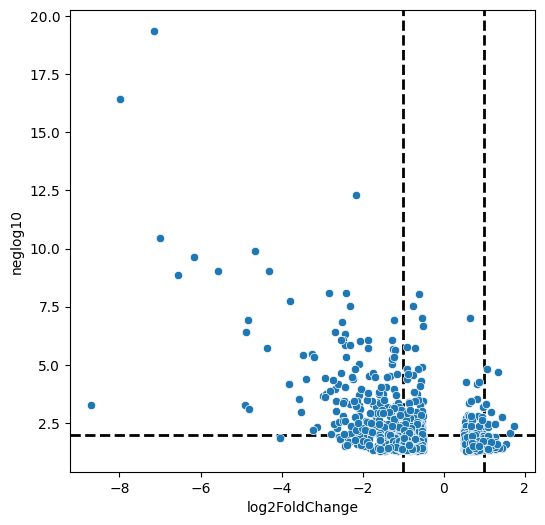

In [ ]:
sigs_df["neglog10"] = -np.log10(sigs_df["padj"])
print(sigs_df.head())

plt.figure(figsize = (6,6))
ax = sns.scatterplot(data = sigs_df,
                     x = "log2FoldChange",
                     y = "neglog10")

#add threshold lines
#horizontal represents adj. p-value cut off
ax.axhline(2, zorder = 0, c = "k", lw = 2, ls = "--")
#vertical lines represont fold-chang thresholds
 #(corresponds to 2x up/down regulation)
 #
ax.axvline(1, zorder = 0, c = "k", lw = 2, ls = "--")
ax.axvline(-1, zorder = 0, c = "k", lw = 2, ls = "--")


# Defining reference genes
reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa']


#assigning
#def map_color(a):
#  log2FoldChange, Symbol, neglog10 = a

 # if abs(log2FoldChange) < 1 or neglog10 < 2:
 #   return "insignificant"
 # if symbol in reference_genes:
 #   return "reference"

 # return "significant"

#sigs_df["color"] = sigs_df["log2FoldChange", "Symbol", "neglog10"].apply(map_color, axis = 1)


In [ ]:
reference_genes_df = pd.DataFrame({
    "gene": ['Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2', 'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa']
})

reference_genes_df.head()

#


,gene
0,Rps29
1,Ctsd
2,Gstp1
3,Gapdh
4,H2az1


/tmp/ipython-input-2123143440.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs_df["neglog10"] = -np.log10(sigs_df["padj"])
/tmp/ipython-input-2123143440.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigs_df['Color'] = 'gray'


                        baseMean  log2FoldChange     lfcSE      stat  \
gene_id                                                                
ENSMUSG00000026728  15911.875870       -0.536429  0.147341 -3.640735   
ENSMUSG00000034248  13640.484577        0.854065  0.306120  2.789969   
ENSMUSG00000024164  13365.013671       -0.529109  0.131086 -4.036360   
ENSMUSG00000026043  12890.452455       -2.641961  0.684262 -3.861035   
ENSMUSG00000024610  12388.944916       -0.512219  0.177472 -2.886201   

                      pvalue      padj    Symbol  neglog10          Color  
gene_id                                                                    
ENSMUSG00000026728  0.000272  0.008896       Vim  2.050823         yellow  
ENSMUSG00000034248  0.005271  0.047592  Slc25a37  1.322470           gray  
ENSMUSG00000024164  0.000054  0.003085        C3  2.510715           gray  
ENSMUSG00000026043  0.000113  0.004997    Col3a1  2.301323  darkturquoise  
ENSMUSG00000024610  0.003899  0.040407 

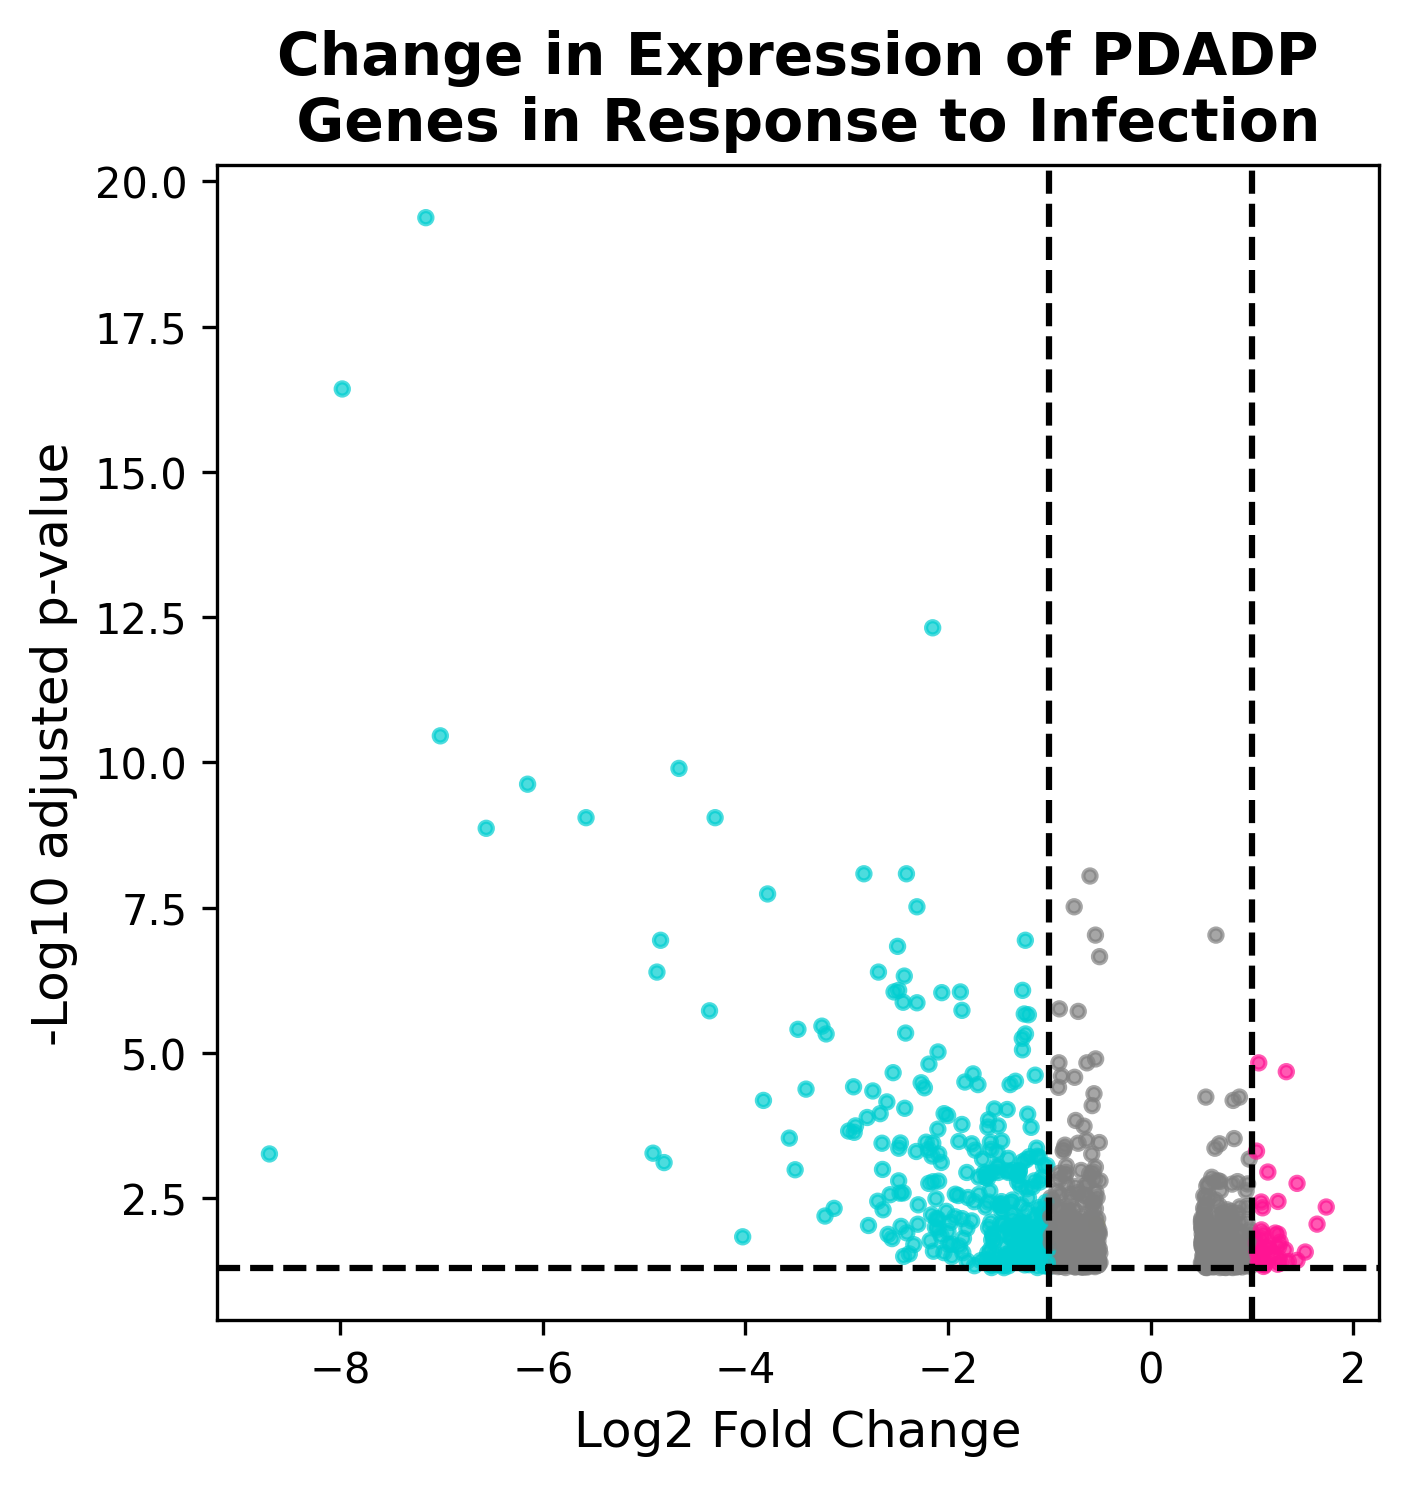

"\nfor gene in reference_genes:\n    if gene in sigs_df.index:\n        x = sigs_df.loc[gene, 'log2FoldChange']\n        y = sigs_df.loc[gene, 'neglog10']\n        ax.scatter(x, y, c='gold', s=200, marker='.',\n                  edgecolors='yellow', linewidth=1, zorder=5)\n        ax.annotate(gene, (x, y),\n                   xytext=(5, 5), textcoords='offset points',\n                   fontsize=14, fontweight='bold', color='k',\n                   bbox=dict(boxstyle='round,pad=0.3',\n                           facecolor='none',\n                           alpha=0.7,\n                           edgecolor='none'))\n"

In [ ]:
# Defining reference genes
reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa']

#volcano plot
sigs_df["neglog10"] = -np.log10(sigs_df["padj"])
print(sigs_df.head())

#plot
sigs_df['Color'] = 'gray'
sigs_df.loc[
    (sigs_df['padj'] < 0.05) & (sigs_df['log2FoldChange'] > 1),
    'Color'
] = 'deeppink'
sigs_df.loc[
    (sigs_df['padj'] < 0.05) & (sigs_df['log2FoldChange'] < -1),
    'Color'
] = 'darkturquoise'
sigs_df.loc[sigs_df['Symbol'].isin(reference_genes),"Color"]="yellow"


print('---')

plt.figure(figsize=(5,5), dpi=300)
plt.scatter(
    sigs_df['log2FoldChange'],
    sigs_df['neglog10'],
    c=sigs_df['Color'],
    alpha=0.7,
    s=10
)

plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-Log10 adjusted p-value', fontsize=12)
plt.title('Change in Expression of PDADP\n Genes in Response to Infection', fontsize=14, fontweight='bold')

# significance thresholds
plt.axhline(y=1.3, linestyle='--', color='black')
plt.axvline(x=1, linestyle='--', color='black')
plt.axvline(x=-1, linestyle='--', color='black')
ax.set_facecolor('#1e1e1e')





#labeling reference genes
#goi = sigs_df[sigs_df["Symbol"].isin(reference_genes)]

#plt.scatter(
#    goi["log2FoldChange"],
#    goi["neglog10"],
#    color="red",
#    s=40,
#    label="Genes of interest"
#)

#for _, row in goi.iterrows():
#    plt.text(
#        row["log2FoldChange"],
#        row["neglog10"],
#        row["Symbol"],
#        fontsize=9,
#        ha="left",
#        va="bottom",
#        color="red"
#   )



plt.show()


#labeling reference gene failures
#ref_df = sigs_df.loc[sigs_df['Symbol'].isin(reference_genes),:]
#plt.scatter(ref_df["log2FoldChange"], ref_df["neglog10"],
#           color = "yellow", s = 50, edgecolor = "black", label = "reference_genes")
#plt.show()
"""
for gene in reference_genes:
    if gene in sigs_df.index:
        x = sigs_df.loc[gene, 'log2FoldChange']
        y = sigs_df.loc[gene, 'neglog10']
        ax.scatter(x, y, c='gold', s=200, marker='.',
                  edgecolors='yellow', linewidth=1, zorder=5)
        ax.annotate(gene, (x, y),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=14, fontweight='bold', color='k',
                   bbox=dict(boxstyle='round,pad=0.3',
                           facecolor='none',
                           alpha=0.7,
                           edgecolor='none'))
"""

#goi_df = sigs_df[sigs_df["genes"].isin(reference_genes)]

#plt.scaatter(
 #   goi_df["log2FoldChange"],
  #  goi_df["neglog10"],
  #  c = "yellow",
  #  s = 60,
  #  edgecolor = "black",
   # label = "Genes of Interest"
#)


In [ ]:
sigs_df.to_csv("sigs_df.csv", index = False)

-----**BAR** **PLOT**-----

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-2686551764.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_barplot_filt_df["average_fpkm"] = healthy_barplot_filt_df[["Ctrl_BM1_fpkm", "Ctrl_BM2_fpkm", "Ctrl_BM3_fpkm",
/tmp/ipython-input-2686551764.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  healthy_barplot_filt_df["log_avg_fpkm"] = np.log10(healthy_barplot_filt_df['average_fpkm'])


      gene_name  Ctrl_BM1_fpkm  Ctrl_BM2_fpkm  Ctrl_BM3_fpkm  Ctrl_BM4_fpkm  \
2           Ngp    5967.173355    7173.035607    5845.204014    5283.768792   
998       Rps29     283.756676     313.389686     267.307755     271.631944   
41        Hspa8     263.260927     254.244539     240.826268     257.273824   
187        Ctsd     231.827306     211.960817     230.259698     194.951363   
116       Aldoa     206.325538     217.475267     191.429322     183.399078   
50          Pkm     205.360558     214.226310     185.803043     161.785047   
72        Rack1     182.484763     182.909818     168.209144     171.020797   
73          Vim     170.531482     164.516151     162.768381     126.980745   
89          Tkt     110.749433     114.399448     104.375460      97.085775   
226      Eif4a1     105.290862     102.274037      98.884082     104.557401   
1425      Snrpb      78.593327      77.057673      75.282195      77.715068   
668        Tpi1      79.937959      78.034417      7

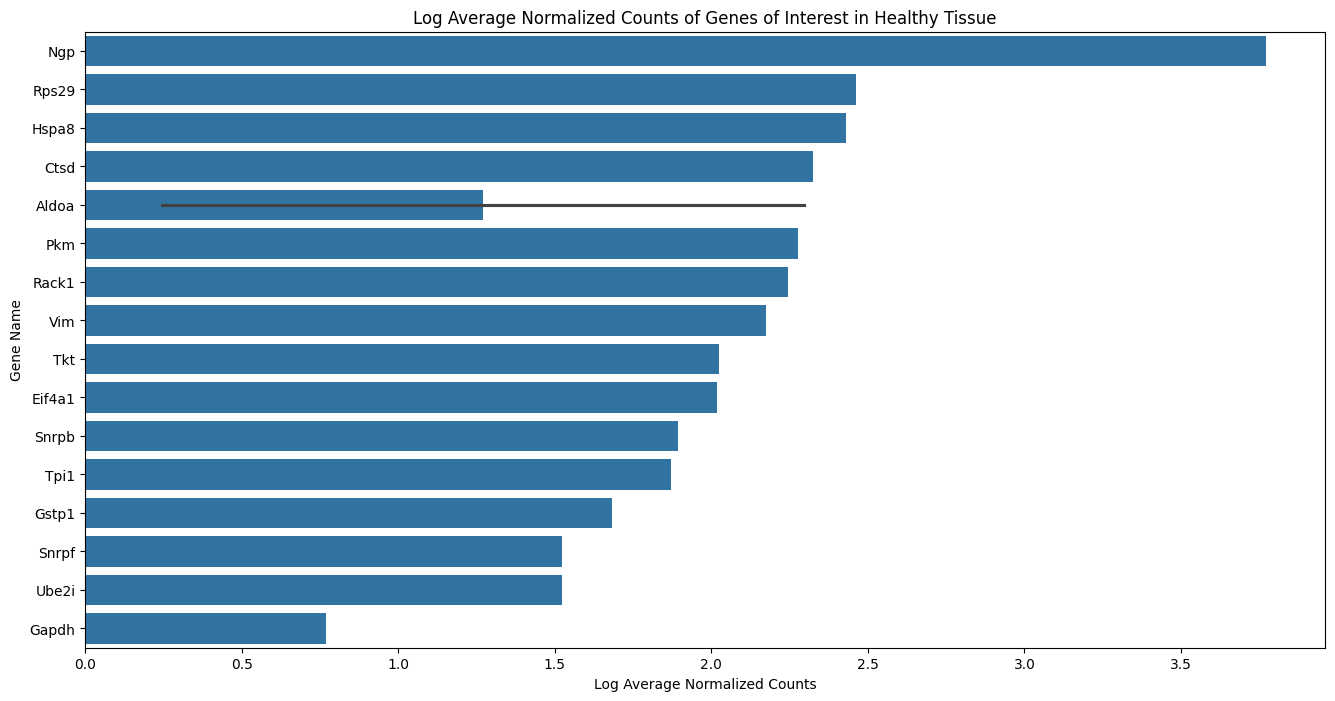

<Figure size 640x480 with 0 Axes>

In [ ]:
#Ngp is positive control, C3 is negative control
barplot_genes_df = pd.DataFrame({
    "gene": ['Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2', 'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa', 'Ngp']
})

#print(barplot_genes_df.head())


#barplot
barplot_df1 = barplot_df.loc[:, ~barplot_df.columns.str.contains("gene_id")]
barplot_df1 = barplot_df1.loc[:, ~barplot_df1.columns.str.contains("count")]
#print(barplot_df1.head())


#healthy barplot
healthy_barplot_df = barplot_df1.loc[:, ~barplot_df1.columns.str.contains("Inf")]
#print(healthy_barplot_df.head())
#filtering based on genes of iterest
healthy_barplot_filt_df = healthy_barplot_df[healthy_barplot_df["gene_name"].isin(barplot_genes_df["gene"])]


#print(healthy_barplot_filt_df.head)

#creating a new column to average across the columns in healthy barplot
healthy_barplot_filt_df["average_fpkm"] = healthy_barplot_filt_df[["Ctrl_BM1_fpkm", "Ctrl_BM2_fpkm", "Ctrl_BM3_fpkm",
                                                        "Ctrl_BM4_fpkm", "Ctrl_BM5_fpkm", "Ctrl_BM6_fpkm"]].mean(axis=1)

#creating a new column for log of average fpkms
healthy_barplot_filt_df["log_avg_fpkm"] = np.log10(healthy_barplot_filt_df['average_fpkm'])
healthy_barplot_filt_df = healthy_barplot_filt_df.sort_values(by="average_fpkm", ascending=False)
print(healthy_barplot_filt_df.head(20))



#making barplot

plt.figure(figsize=(16, 8))
sns.barplot(data = healthy_barplot_filt_df, y = "gene_name", x = "log_avg_fpkm")
plt.ylabel("Gene Name")
plt.xlabel("Log Average Normalized Counts")
plt.title("Log Average Normalized Counts of Genes of Interest in Healthy Tissue")
plt.show()

plt.savefig("bar_plot_healthy.png", dpi = 300, bbox_inches = "tight")


In [ ]:

nonzero = healthy_barplot_filt_df.loc[healthy_barplot_filt_df["log_avg_fpkm"] != 0, "log_avg_fpkm"].min()
#neg_control = healthy_barplot_filt_df.loc[healthy_barplot_filt_df["log_avg_fpkm"].idxmin(), "gene_name"]
print(nonzero)

-inf


/tmp/ipython-input-1981711254.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infected_barplot_filt_df["average_fpkm"] = infected_barplot_filt_df[["Inf_BM1_fpkm", "Inf_BM2_fpkm", "Inf_BM3_fpkm",
/tmp/ipython-input-1981711254.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  infected_barplot_filt_df["log_avg_fpkm"] = np.log10(infected_barplot_filt_df['average_fpkm'])


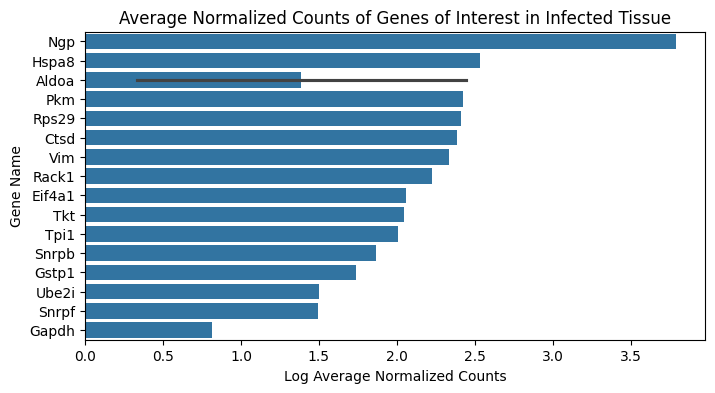

In [ ]:
#infected barplot
#Ngp is negative control, C3 is positive control
barplot_genes_df = pd.DataFrame({
    "gene": ['Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2', 'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa', 'Stfpc', 'Ngp']
})

#print(barplot_genes_df.head())


#infected barplot
infected_barplot_df = barplot_df1.loc[:, ~barplot_df1.columns.str.contains("Ctrl")]
#print(infected_barplot_df.head())
#filtering based on genes of iterest
infected_barplot_filt_df = infected_barplot_df[infected_barplot_df["gene_name"].isin(barplot_genes_df["gene"])]
#print(infected_barplot_filt_df.head())

#creating a new column to average across the columns in infected barplot
infected_barplot_filt_df["average_fpkm"] = infected_barplot_filt_df[["Inf_BM1_fpkm", "Inf_BM2_fpkm", "Inf_BM3_fpkm",
                                                                  "Inf_BM4_fpkm", "Inf_BM5_fpkm", "Inf_BM6_fpkm"]].mean(axis=1)

#creating a new column for log of average fpkms
infected_barplot_filt_df["log_avg_fpkm"] = np.log10(infected_barplot_filt_df['average_fpkm'])


#print(infected_barplot_filt_df.head())



infected_barplot_filt_df = infected_barplot_filt_df.sort_values(by="log_avg_fpkm", ascending=False)
#making barplot

plt.figure(figsize=(8, 4))
sns.barplot(data = infected_barplot_filt_df, y = "gene_name", x = "log_avg_fpkm")
plt.ylabel("Gene Name")
plt.xlabel("Log Average Normalized Counts")
plt.title("Average Normalized Counts of Genes of Interest in Infected Tissue")
plt.show()

ax.set_facecolor("#f4f2e6")



In [ ]:
import numpy as np

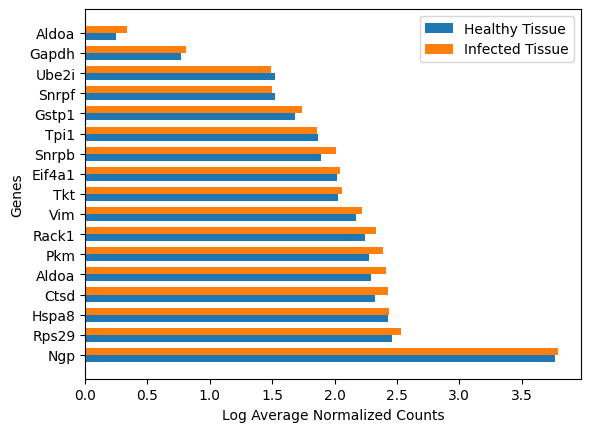

In [ ]:
#dodged barplot

#dataframe for healthy: healthy_barplot_filt_df
#dataframe for infected: infected_barplot_filt_df

y = np.arange(len(healthy_barplot_filt_df["gene_name"]))
width = 0.35

fig, ax = plt.subplots()

ax.barh(y - width/2, healthy_barplot_filt_df["log_avg_fpkm"], width, label = "Healthy Tissue")
ax.barh(y + width/2, infected_barplot_filt_df["log_avg_fpkm"], width, label = "Infected Tissue")

ax.set_yticks(y)
ax.set_yticklabels(healthy_barplot_filt_df["gene_name"])
ax.set_xlabel("Log Average Normalized Counts")
ax.set_ylabel("Genes")
ax.legend()

plt.show()



GENE CORRELATION IN BULK




In [ ]:
import pandas as pd
merged_df = pd.read_csv("merged_df.csv")

# Make sure you're using the correct dataframe
# Use the one AFTER your filtering but BEFORE transpose

word_to_remove = 'count'
corr_df = merged_df.filter(regex=f'^(?!.*{word_to_remove}).*$')

if 'gene_id' in corr_df.columns:
    corr_df = corr_df.drop('gene_id', axis=1)

# Calculate metric (variance, mean, etc.) on genes before dropping
# Assuming you want to filter genes (rows) by some metric
if 'gene_name' in corr_df.columns:
    # Set gene_name as index
    corr_df = corr_df.set_index('gene_name')

# Calculate variance for each gene (row)
gene_variances = corr_df.var(axis=1)  # axis=1 means across columns (samples)
sorted_genes = gene_variances.sort_values(ascending=True)  # Lowest variance first

print(f"Total genes: {len(sorted_genes)}")
print(f"\nLowest variance genes (first 10):")
print(sorted_genes.head(10))

# Drop the N genes with lowest variance
N = 51000
genes_to_drop = sorted_genes.index[:N]

# Check which genes actually exist
existing_genes = [g for g in genes_to_drop if g in corr_df.index]
missing_genes = [g for g in genes_to_drop if g not in corr_df.index]

print(f"\nGenes to drop: {N}")
print(f"Genes found in dataframe: {len(existing_genes)}")
print(f"Genes NOT found: {len(missing_genes)}")
corr_df.to_csv("corr_df.csv", index=True)

if missing_genes:
    print(f"Missing genes (first 10): {missing_genes[:10]}")

# Drop only the genes that exist
dropped_df = corr_df.drop(index=existing_genes)  # Use index, not columns!

print(f"\nOriginal shape: {corr_df.shape}")
print(f"New shape: {dropped_df.shape}")
print(f"Genes remaining: {dropped_df.shape[0]}")

# Now transpose for correlation
swapped_df = dropped_df.T

print(f"\nAfter transpose:")
print(f"Shape: {swapped_df.shape}")
print(f"Samples (rows): {swapped_df.shape[0]}")
print(f"Genes (columns): {swapped_df.shape[1]}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Your reference genes
reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa'
]

# Use the correctly formatted data
gene_df = swapped_df.copy()

print("=== Calculating Correlations with Reference Genes ===")
print(f"Total genes in dataset: {gene_df.shape[1]}")
print(f"Total samples: {gene_df.shape[0]}")

# Check which reference genes are present
genes_in_data = [gene for gene in reference_genes if gene in gene_df.columns]
genes_missing = [gene for gene in reference_genes if gene not in gene_df.columns]

print(f"\n✓ Reference genes found: {len(genes_in_data)}/{len(reference_genes)}")
print(f"Found: {genes_in_data}")

if genes_missing:
    print(f"⚠ Missing: {genes_missing}")

if genes_in_data:
    # Calculate correlation of ALL genes with each reference gene
    print("\n=== Creating correlation matrix ===")
    ref_vs_all_corr = pd.DataFrame()

    for ref_gene in genes_in_data:
        ref_vs_all_corr[ref_gene] = gene_df.corrwith(gene_df[ref_gene])

    print(f"Correlation matrix shape: {ref_vs_all_corr.shape}")

    # Save full correlation matrix
    ref_vs_all_corr.to_csv("reference_genes_vs_all_genes_correlation.csv")
    print("✓ Saved: reference_genes_vs_all_genes_correlation.csv")

    # Find genes highly correlated with reference genes
    ref_vs_all_corr['mean_abs_corr'] = ref_vs_all_corr.abs().mean(axis=1)
    highly_correlated = ref_vs_all_corr[ref_vs_all_corr['mean_abs_corr'] > 0.7].sort_values('mean_abs_corr', ascending=False)

    print(f"\n=== Genes highly correlated with reference genes (mean |r| > 0.7) ===")
    print(f"Found {len(highly_correlated)} genes")
    print(highly_correlated.head(20))

    highly_correlated.to_csv("highly_correlated_with_reference_genes.csv")
    print("✓ Saved: highly_correlated_with_reference_genes.csv")

    # Select top N genes for visualization
    top_n = 100  # Increased to show more genes
    top_genes = ref_vs_all_corr['mean_abs_corr'].nlargest(top_n).index

    # Create subset for clustering
    corr_subset = ref_vs_all_corr.loc[top_genes, genes_in_data]

    print(f"\n=== Creating clustered heatmap with top {top_n} genes ===")

    # Create clustered heatmap using seaborn's clustermap
    # This automatically performs hierarchical clustering on both axes
    g = sns.clustermap(corr_subset,
                       cmap='RdBu_r',
                       center=0,
                       vmin=-1,
                       vmax=1,
                       figsize=(16, 20),
                       cbar_kws={'label': 'Correlation'},
                       yticklabels=True,
                       xticklabels=True,
                       method='average',  # linkage method: 'average', 'complete', 'single', 'ward'
                       metric='euclidean',  # distance metric
                       row_cluster=True,  # cluster rows (genes)
                       col_cluster=True,  # cluster columns (reference genes)
                       dendrogram_ratio=0.1,
                       cbar_pos=(1, 0.83, 0.03, 0.15))
    plt.xticks(rotation=90)

    g.fig.suptitle(f'',
                   fontsize=16, y=0.995)
    g.ax_heatmap.set_xlabel('Reference Genes', fontsize=12)
    g.ax_heatmap.set_ylabel('All Genes (clustered)', fontsize=12)

    plt.savefig('clustered_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Also create a focused version with just highly correlated genes
    if len(highly_correlated) > 10:
        print(f"\n=== Creating clustered heatmap with highly correlated genes (n={len(highly_correlated)}) ===")

        highly_corr_subset = ref_vs_all_corr.loc[highly_correlated.index, genes_in_data]

        g2 = sns.clustermap(highly_corr_subset,
                           cmap='RdBu_r',
                           center=0,
                           vmin=-1,
                           vmax=1,
                           figsize=(14, max(12, len(highly_correlated)*0.3)),
                           cbar_kws={'label': 'Correlation'},
                           yticklabels=True,
                           xticklabels=True,
                           method='average',
                           metric='euclidean',
                           row_cluster=True,
                           col_cluster=True,
                           linewidths=0.5)


        # Make tick labels bigger
        g2.ax_heatmap.tick_params(axis='both', which='major', labelsize=12)
        g2.ax_heatmap.set_xticklabels(g2.ax_heatmap.get_xticklabels(), fontsize=22, weight='bold')
        g2.ax_heatmap.set_yticklabels(g2.ax_heatmap.get_yticklabels(), fontsize=22, weight='bold')
        g2.xticks(rotation=90)

        # Make colorbar label bigger
        cbar2 = g2.ax_cbar
        cbar2.set_ylabel('Correlation', fontsize=14, weight='bold')
        cbar2.tick_params(labelsize=12)

        g2.fig.suptitle(f'Highly Correlated Genes (mean |r| > 0.7)',
                       fontsize=18, y=0.998, weight='bold')
        g2.ax_heatmap.set_xlabel('Reference Genes', fontsize=14, weight='bold')
        g2.ax_heatmap.set_ylabel('Highly Correlated Genes (clustered)', fontsize=14, weight='bold')

        plt.savefig('clustered_highly_correlated_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        g2.fig.suptitle(f'',
                       fontsize=16, y=0.998)
        g2.ax_heatmap.set_xlabel('PDADP Genes', fontsize=12)
        g2.ax_heatmap.set_ylabel('Correlated Genes', fontsize=12)

        plt.savefig('clustered_highly_correlated_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Extract cluster assignments from the clustermap
    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind

    clustered_genes = corr_subset.index[row_order].tolist()
    clustered_ref_genes = corr_subset.columns[col_order].tolist()

    print("\n=== Cluster Order ===")
    print(f"Reference genes (clustered order): {clustered_ref_genes}")
    print(f"\nTop 20 genes (clustered order): {clustered_genes[:20]}")

    # Save clustered order
    pd.DataFrame({
        'Gene': clustered_genes,
        'Cluster_Order': range(len(clustered_genes))
    }).to_csv('clustered_gene_order.csv', index=False)

    pd.DataFrame({
        'Reference_Gene': clustered_ref_genes,
        'Cluster_Order': range(len(clustered_ref_genes))
    }).to_csv('clustered_reference_gene_order.csv', index=False)

    print("\n✓ Saved cluster orders to CSV files")

    # Summary statistics by cluster
    print("\n=== Correlation Summary by Reference Gene ===")
    for ref_gene in genes_in_data:
        corrs = ref_vs_all_corr[ref_gene].dropna()
        high_pos = (corrs > 0.7).sum()
        high_neg = (corrs < -0.7).sum()
        print(f"\n{ref_gene}:")
        print(f"  Highly positively correlated (r > 0.7): {high_pos}")
        print(f"  Highly negatively correlated (r < -0.7): {high_neg}")
        print(f"  Mean correlation: {corrs.mean():.3f}")

else:
    print("\n No reference genes found in the dataset!")

In [ ]:
# Calculate correlation matrix (genes vs genes)
matrix = gene_df.corr()

print(f"\nCorrelation matrix shape: {matrix.shape}")
print(f"Sample correlations:")
print(matrix.iloc[:5, :5])

matrix.to_csv("gene_matrix.csv", index=False)

Adding Gene ontology to Heatmap

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

# 1. SET NUMBER OF CLUSTERS (Increase this to avoid 'super large groups')
n_clusters = 6
palette = sns.color_palette("husl", n_clusters)
cluster_colors_map = {i+1: palette[i] for i in range(n_clusters)}

# 2. HIERARCHICAL CLUSTERING
data_for_clustering = corr_subset
row_linkage = linkage(pdist(data_for_clustering), method='ward') # 'ward' minimizes variance within clusters

# Cut into smaller, more specific functional groups
gene_clusters = pd.DataFrame({
    'Gene': data_for_clustering.index,
    'Cluster': fcluster(row_linkage, t=n_clusters, criterion='maxclust')
}).set_index('Gene')

# 3. FUNCTIONAL ANNOTATION (GO per small cluster)
cluster_names = {}
for cluster_id in range(1, n_clusters + 1):
    gene_list = gene_clusters[gene_clusters['Cluster'] == cluster_id].index.tolist()
    try:
        enr = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2023'],
                         organism='Mouse',
                         cutoff=0.05)
        res = enr.results
        if not res[res['Adjusted P-value'] < 0.05].empty:
            # Take the top significant term as the cluster name
            top_term = res.iloc[0]['Term'].split(' (GO')[0]
            cluster_names[cluster_id] = f"C{cluster_id}: {top_term}"
        else:
            cluster_names[cluster_id] = f"C{cluster_id}: Mixed Functions"
    except:
        cluster_names[cluster_id] = f"C{cluster_id}: General"

# 4. PLOTTING WITH COLORED GENE NAMES
row_colors = gene_clusters['Cluster'].map(cluster_colors_map)

g = sns.clustermap(corr_subset,
                   row_linkage=row_linkage,
                   row_colors=row_colors,
                   cmap='RdBu_r',
                   center=0,
                   figsize=(14, 22),
                   yticklabels=True,
                   dendrogram_ratio=(0.1, 0.05))

# Apply colors to the Y-axis gene labels
for tick_label in g.ax_heatmap.get_yticklabels():
    gene_name = tick_label.get_text()
    c_id = gene_clusters.loc[gene_name, 'Cluster']
    tick_label.set_color(cluster_colors_map[c_id])
    tick_label.set_weight('bold')
    tick_label.set_fontsize(9)


# Create Legend for specific functional categories
legend_patches = [mpatches.Patch(color=cluster_colors_map[i], label=cluster_names[i])
                  for i in range(1, n_clusters + 1)]

plt.legend(handles=legend_patches, title='Functional Categories',
           bbox_to_anchor=(2, 1), loc='upper right', frameon=False, fontsize=10)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patches import Patch

# 1. Clean data and ensure it is not empty
corr_clean = corr_subset.dropna(axis=0, how='all').dropna(axis=1, how='all')
corr_clean = corr_clean.fillna(0).replace([np.inf, -np.inf], 0)

if corr_clean.empty:
    print("Matrix is empty. Check your 'top_genes' list.")
else:
    # 2. Get Annotations
    gene_functions = get_go_annotations_v2(corr_clean.index.tolist())

    # 3. Clustering and Sorting
    Z = linkage(corr_clean, method='ward')
    # Get the 2 main clusters
    cluster_labels = fcluster(Z, 2, criterion='maxclust')

    sort_df = pd.DataFrame({
        'Cluster': cluster_labels,
        'Function': [gene_functions.get(g, 'Other/Unknown') for g in corr_clean.index]
    }, index=corr_clean.index)

    # Sort by Cluster (the 2 big groups) then by Function within them
    sort_df = sort_df.sort_values(by=['Cluster', 'Function'])
    corr_sorted = corr_clean.loc[sort_df.index, sort_df.index]

    # 4. Color Mapping
    unique_funcs = sorted(list(set(sort_df['Function'])))
    palette = sns.color_palette('husl', len(unique_funcs))
    lut = dict(zip(unique_funcs, palette))
    # FORCE Uncategorized/Other to Dark Grey
    lut['Other/Unknown'] = '#4D4D4D'
    if 'Uncategorized' in lut: lut['Uncategorized'] = '#4D4D4D'

    # 5. Plotting with a smaller figsize to prevent blank output
    plt.figure(figsize=(12, 12)) # Reduced size
    g = sns.clustermap(corr_sorted,
                       cmap='RdBu_r',
                       center=0,
                       vmin=-1, vmax=1,
                       row_cluster=False, # Use our custom sort
                       col_cluster=False,
                       figsize=(14, 14), # Slightly smaller
                       yticklabels=True,
                       xticklabels=True,
                       dendrogram_ratio=0.1)

    # 6. Coloring Text Labels
    ax = g.ax_heatmap
    for label in ax.get_yticklabels():
        gene_name = label.get_text()
        func = gene_functions.get(gene_name, 'Other/Unknown')
        label.set_color(lut.get(func, '#4D4D4D'))
        label.set_weight('bold')
        label.set_fontsize(8)

    # 7. Legend
    legend_elements = [Patch(facecolor=color, label=name) for name, color in lut.items()]
    g.fig.legend(handles=legend_elements, title="Functions",
                 loc='upper right', bbox_to_anchor=(1.25, 0.8))

    plt.show()

In [ ]:
available_ref_genes = [g for g in reference_genes if g in matrix.columns]
missing_ref_genes = [g for g in reference_genes if g not in matrix.columns]

print(f"Found {len(available_ref_genes)} out of {len(reference_genes)} reference genes")
if missing_ref_genes:
    print(f"Missing reference genes: {missing_ref_genes}")

# For each gene, calculate its average correlation with the reference genes
avg_correlations = {}
for gene in matrix.columns:
    if gene in available_ref_genes:
        # Reference genes automatically pass
        avg_correlations[gene] = 1.0
    else:
        # Calculate average absolute correlation with reference genes
        corr_values = [abs(matrix.loc[gene, ref_gene])
                      for ref_gene in available_ref_genes
                      if ref_gene in matrix.columns]
        avg_correlations[gene] = np.mean(corr_values) if corr_values else 0

# Convert to series for easier manipulation
correlation_scores = pd.Series(avg_correlations).sort_values(ascending=False)

# Set correlation threshold (adjust this value as needed)
correlation_threshold = 0.63  # Keep genes with avg correlation >= 0.63

# Filter genes
genes_to_keep = correlation_scores[correlation_scores >= correlation_threshold].index.tolist()
genes_to_remove = correlation_scores[correlation_scores < correlation_threshold].index.tolist()

print(f"\n=== Filtering Results ===")
print(f"Correlation threshold: {correlation_threshold}")
print(f"Genes to keep: {len(genes_to_keep)}")
print(f"Genes to remove: {len(genes_to_remove)}")

# Create filtered dataframe
filtered_df = swapped_df[genes_to_keep]
filtered_df.to_csv("filtered_df.csv", index=False)


print(f"\nOriginal shape: {swapped_df.shape}")
print(f"Filtered shape: {filtered_df.shape}")

In [ ]:
# Show statistics
print(f"\n=== Correlation Statistics ===")
print(f"Mean correlation score: {correlation_scores.mean():.7f}")
print(f"Median correlation score: {correlation_scores.median():.7f}")
print(f"Min correlation score: {correlation_scores.min():.7f}")
print(f"Max correlation score: {correlation_scores.max():.7f}")

# Show top and bottom genes by correlation
print(f"\n=== Top 10 Genes (Highest Correlation) ===")
print(correlation_scores.head(10))

print(f"\n=== Bottom 10 Genes (Lowest Correlation) ===")
print(correlation_scores.tail(10))

# Save results
correlation_scores.to_csv("gene_correlation_scores.csv", header=['avg_correlation'])
filtered_df.to_csv("filtered_gene_expression.csv", index=True)
print(filtered_df)

print("\n✓ Saved 'gene_correlation_scores.csv' with correlation scores")
print("✓ Saved 'filtered_gene_expression.csv' with filtered data")

In [ ]:
# Create heatmap of gene-gene correlations for filtered genes
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== Creating Correlation Heatmap ===")

# Calculate correlation matrix for filtered genes only
filtered_correlation_matrix = filtered_df.corr()

# Create figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(filtered_correlation_matrix,
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation"},
            xticklabels=True,
            yticklabels=True)

plt.title(f'Gene-Gene Correlation Heatmap\n({len(genes_to_keep)} genes with correlation ≥ {correlation_threshold})',
          fontsize=14, pad=20)
plt.xlabel('Genes', fontsize=12)
plt.ylabel('Genes', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()

# Save figure
plt.savefig('gene_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved 'gene_correlation_heatmap.png'")

plt.show()

print(f"\nHeatmap dimensions: {filtered_correlation_matrix.shape[0]} genes × {filtered_correlation_matrix.shape[1]} genes")

In [ ]:
# Gene Ontology Analysis and Functional Clustering for Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import requests
import time

print("\n=== Gene Ontology Analysis and Functional Clustering ===")

# Calculate correlation matrix for filtered genes only
filtered_correlation_matrix = filtered_df.corr()

# Filter to keep only reference genes that are in the filtered dataset
available_ref_genes_filtered = [g for g in reference_genes if g in filtered_correlation_matrix.columns]
print(f"PDADP genes available in filtered data: {len(available_ref_genes_filtered)} out of {len(reference_genes)}")

# Crop to show only reference genes on x-axis, all filtered genes on y-axis
cropped_correlation_matrix = filtered_correlation_matrix.loc[:, available_ref_genes_filtered]

# Get non-reference genes (genes to analyze)
all_genes = cropped_correlation_matrix.index.tolist()
non_reference_genes = [g for g in all_genes if g not in reference_genes]
print(f"\nTotal genes to analyze: {len(non_reference_genes)}")
print(f"Sample genes: {non_reference_genes[:10]}")

# ===== GENE ONTOLOGY ENRICHMENT ANALYSIS =====
print("\n=== Performing GO Enrichment Analysis ===")

def query_enrichr(gene_list, organism='Mouse'):
    """
    Query Enrichr API for GO analysis
    """
    # Enrichr API endpoints
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    query_string = '\n'.join(gene_list)

    payload = {
        'list': (None, query_string),
    }

    try:
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')

        data = response.json()
        return data
    except Exception as e:
        print(f"Error querying Enrichr: {e}")
        return None

def get_enrichr_results(user_list_id, gene_set_library='GO_Biological_Process_2023'):
    """
    Get enrichment results from Enrichr
    """
    ENRICHR_URL = f'https://maayanlab.cloud/Enrichr/enrich'
    query_string = f'?userListId={user_list_id}&backgroundType={gene_set_library}'

    try:
        response = requests.get(ENRICHR_URL + query_string)
        if not response.ok:
            raise Exception('Error fetching enrichment results')

        data = response.json()
        return data
    except Exception as e:
        print(f"Error getting results: {e}")
        return None

# Submit gene list to Enrichr
enrichr_data = query_enrichr(non_reference_genes)
go_terms_df = None
results = None

if enrichr_data:
    user_list_id = enrichr_data['userListId']
    print(f"✓ Gene list submitted successfully (ID: {user_list_id})")

    # Get GO Biological Process results
    time.sleep(2)  # Increased pause to allow processing
    results = get_enrichr_results(user_list_id, 'GO_Biological_Process_2023')

    if results and 'GO_Biological_Process_2023' in results:
        go_results = results['GO_Biological_Process_2023']

        if len(go_results) > 0:
            # Parse results
            go_terms_df = pd.DataFrame(go_results, columns=[
                'Rank', 'Term', 'P-value', 'Odds Ratio', 'Combined Score',
                'Overlapping Genes', 'Adjusted P-value', 'Old P-value', 'Old Adjusted P-value'
            ])

            print(f"✓ Found {len(go_results)} GO terms")
            print("\nTop 10 enriched GO terms:")
            print(go_terms_df[['Term', 'Adjusted P-value', 'Overlapping Genes']].head(10))

            # Save full results
            go_terms_df.to_csv('go_enrichment_results.csv', index=False)
            print("\n✓ Saved 'go_enrichment_results.csv'")
        else:
            print("⚠ No GO terms found in results")
    else:
        print("⚠ No results returned from Enrichr")
else:
    print("⚠ Failed to submit genes to Enrichr")

# ===== MANUAL FUNCTIONAL CATEGORIZATION =====
print("\n=== Creating Functional Categories ===")

# Create a mapping of genes to functional categories
gene_categories = {}

# Create case-insensitive lookup for gene names
gene_name_lookup = {gene.upper(): gene for gene in non_reference_genes}

# Parse top GO terms to assign genes to categories
if go_terms_df is not None and len(go_terms_df) > 0:
    # Define broad functional categories
    category_keywords = {
        'Protein Processing': ['protein', 'translation', 'folding', 'modification', 'ribosom', 'peptide'],
        'Metabolism': ['metabolic', 'metabolism', 'biosynthetic', 'catabolic', 'oxidation', 'glycol'],
        'Cell Cycle': ['cell cycle', 'mitosis', 'division', 'proliferation', 'g1', 'g2', 's phase'],
        'Signaling': ['signaling', 'signal transduction', 'pathway', 'cascade', 'receptor'],
        'Transport': ['transport', 'localization', 'trafficking', 'secretion', 'export', 'import'],
        'Immune Response': ['immune', 'inflammatory', 'defense', 'response to', 'cytokine'],
        'Cell Structure': ['cytoskeleton', 'adhesion', 'junction', 'membrane', 'structural'],
        'Transcription': ['transcription', 'gene expression', 'RNA', 'splicing'],
        'DNA Repair': ['DNA repair', 'DNA damage', 'checkpoint', 'recombination'],
        'Apoptosis': ['apoptosis', 'cell death', 'programmed cell death', 'necrosis']
    }

    genes_assigned = set()

    # Assign each gene to categories based on GO terms
    for idx, row in go_terms_df.head(100).iterrows():  # Increased to top 100 GO terms
        term = row['Term'].lower()

        # Handle both list and string formats for genes
        genes_in_term = row['Overlapping Genes']
        if isinstance(genes_in_term, str):
            genes_in_term = genes_in_term.split(';')
        elif isinstance(genes_in_term, list):
            genes_in_term = genes_in_term
        else:
            continue

        # Determine category
        assigned_category = 'Other'
        for category, keywords in category_keywords.items():
            if any(keyword in term for keyword in keywords):
                assigned_category = category
                break

        # Assign genes to categories (case-insensitive matching)
        for gene in genes_in_term:
            if isinstance(gene, str):
                gene_upper = gene.strip().upper()
            else:
                gene_upper = str(gene).strip().upper()

            # Look up the original gene name (with correct case)
            if gene_upper in gene_name_lookup:
                original_gene = gene_name_lookup[gene_upper]
                if original_gene not in gene_categories:
                    gene_categories[original_gene] = assigned_category
                    genes_assigned.add(original_gene)
                    print(f"  Assigned {original_gene} to {assigned_category} (from: {row['Term'][:60]}...)")

    print(f"\n✓ Assigned {len(genes_assigned)} genes to categories from GO terms")

else:
    print("⚠ No GO terms available, using alternative categorization method")

    # Alternative: Simple functional categorization based on gene name patterns
    # This is a fallback when GO enrichment doesn't work
    name_patterns = {
        'Metabolism': ['Aldoa', 'Eno', 'Pgk', 'Pkm', 'Gapdh', 'Ldh', 'Idh', 'Tpi', 'Pgam', 'Tkt', 'Akr'],
        'Protein Processing': ['Rps', 'Rpl', 'Eif', 'Hspa', 'Hsp', 'Dnaj', 'Mrpl'],
        'Signaling': ['Map', 'Erk', 'Akt', 'Stat', 'Jak'],
        'Transcription': ['Hist', 'H2a', 'H3', 'H4', 'Pol'],
        'Cell Structure': ['Vim', 'Tub', 'Act', 'Krt'],
        'Transport': ['Slc', 'Atp'],
        'Ubiquitin System': ['Ub', 'Ube'],
    }

    for gene in non_reference_genes:
        assigned = False
        for category, patterns in name_patterns.items():
            if any(pattern.lower() in gene.lower() for pattern in patterns):
                gene_categories[gene] = category
                assigned = True
                print(f"  Pattern-based: {gene} → {category}")
                break

        if not assigned:
            gene_categories[gene] = 'Other'

# Assign remaining genes to 'Uncategorized'
for gene in non_reference_genes:
    if gene not in gene_categories:
        gene_categories[gene] = 'Uncategorized'

# Print category distribution
category_counts = pd.Series(gene_categories).value_counts()
print("\n=== Gene Distribution by Functional Category ===")
print(category_counts)

# Save gene categories to file
pd.DataFrame(list(gene_categories.items()), columns=['Gene', 'Category']).to_csv('gene_functional_categories.csv', index=False)
print("\n✓ Saved 'gene_functional_categories.csv'")

# ===== CLUSTER GENES BY CATEGORY =====
print("\n=== Organizing Heatmap by Functional Categories ===")

# Sort genes by category
genes_by_category = {}
for gene, category in gene_categories.items():
    if category not in genes_by_category:
        genes_by_category[category] = []
    genes_by_category[category].append(gene)

# Create ordered gene list with PDADP genes at the TOP
ordered_genes = []

# Add PDADP (reference) genes first at the top
ordered_genes.extend([g for g in all_genes if g in reference_genes])

# Then add other genes sorted by category
for category in sorted(genes_by_category.keys()):
    ordered_genes.extend(sorted(genes_by_category[category]))

# Reorder the correlation matrix
ordered_correlation_matrix = cropped_correlation_matrix.loc[ordered_genes, :]

# ===== CREATE COLOR-CODED HEATMAP =====
print("\n=== Creating Annotated Heatmap ===")

# Define colors for each category
category_colors = {
    'Metabolism': '#0173B2',
    'Cell Cycle': '#DE8F05',
    'Signaling': '#029E73',
    'Transport': '#CC78BC',
    'Immune Response': '#D6A67B',
    'Protein Processing': '#949494',
    'Cell Structure': '#D55E00',
    'Transcription': '#85C1E2',
    'DNA Repair': '#F8B739',
    'Apoptosis': '#EC7063',
    'Ubiquitin System': '#52BE80',
    'Other': '#95A5A6',
    'Uncategorized': '#D5D8DC',
    'PDADP genes': '#2C3E50'
}

# Create color list for y-axis labels
gene_label_colors = []
for gene in ordered_genes:
    if gene in reference_genes:
        gene_label_colors.append(category_colors['PDADP genes'])
    else:
        category = gene_categories.get(gene, 'Uncategorized')
        gene_label_colors.append(category_colors.get(category, '#D5D8DC'))

# Create figure with extra space for legend
fig = plt.figure(figsize=(10, 20))
gs = fig.add_gridspec(1, 2, width_ratios=[20, 1], wspace=0.05)
ax = fig.add_subplot(gs[0])

# Create heatmap
hm = sns.heatmap(ordered_correlation_matrix,
                 cmap='coolwarm',
                 center=0,
                 vmin=-1,
                 vmax=1,
                 square=False,
                 linewidths=0,
                 cbar_kws={"shrink": 0.3, "label": "Correlation"},
                 xticklabels=True,
                 yticklabels=True,
                 ax=ax)

# Color the y-axis labels
for ticklabel, color in zip(ax.get_yticklabels(), gene_label_colors):
    ticklabel.set_color(color)
    ticklabel.set_weight('bold')



# Add title
ax.set_title(f'Genes Strongly Correlated with PDADPs',
             fontsize=16, pad=20)
ax.set_xlabel('PDADP Genes', fontsize=12)
ax.set_ylabel('Genes (Colored by Function)', fontsize=14)
ax.tick_params(axis='x', rotation=90, labelsize=11)
ax.tick_params(axis='y', rotation=0, labelsize=11)

# Add category legend
legend_ax = fig.add_subplot(gs[1])
legend_ax.axis('off')

# Create legend patches - PDADP genes first
from matplotlib.patches import Patch
legend_elements = []

# Add PDADP genes first
pdadp_count = len([g for g in ordered_genes if g in reference_genes])
legend_elements.append(Patch(facecolor=category_colors['PDADP genes'],
                             label=f'PDADP genes ({pdadp_count})'))

# Then add other categories
for category in sorted(genes_by_category.keys()):
    count = len(genes_by_category.get(category, []))
    if count > 0:
        legend_elements.append(Patch(facecolor=category_colors.get(category, '#D5D8DC'),
                                     label=f'{category} ({count})'))

legend_ax.legend(handles=legend_elements, loc='upper left',
                fontsize=8, title='Functional Categories',
                title_fontsize=9, frameon=True)

plt.tight_layout()

# Save figure
plt.savefig('gene_correlation_heatmap_go_annotated.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved 'gene_correlation_heatmap_go_annotated.png'")

plt.show()

print(f"\n=== Summary ===")
print(f"Total genes analyzed: {len(non_reference_genes)}")
print(f"PDADP genes: {len([g for g in ordered_genes if g in reference_genes])}")
print(f"Genes categorized: {len([g for g in gene_categories if g in non_reference_genes])}")
print(f"Functional categories: {len(genes_by_category)}")

Principal Component Analysis of Gene-Gene

In [ ]:
#Getting all the packages I need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Set the first column as index (gene names)
filtered_df = pd.read_csv("gene_matrix.csv", index_col=0)

# Transpose so samples are rows and genes are columns
gene_matrix = filtered_df.T
print(gene_matrix.head)
print(f"Gene matrix shape: {gene_matrix.shape}")
print(f"Number of samples (rows): {gene_matrix.shape[0]}")
print(f"Number of genes (columns/features): {gene_matrix.shape[1]}")

# Now standardize and apply PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(gene_matrix)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
from sklearn.impute import SimpleImputer
#Did a PCA
imputer = SimpleImputer(strategy='mean')
scaled_data_imputed = imputer.fit_transform(scaled_data)
pca_result = pca.fit_transform(scaled_data_imputed)

print(f"\nPCA result shape: {pca_result.shape}")
print(pca_result[:2])
print("Explained variance:", pca.explained_variance_ratio_)
print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

In [ ]:
#Make plot
fig, ax = plt.subplots(figsize=(19.2, 14.4))
# Plot all genes as points
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'],
                     alpha=0.7,
                     s=80,
                     c='paleturquoise',
                     edgecolors='darkturquoise',
                     linewidth=0.5)
#Labels
reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa'
]

# Get PC ranges for determining overlap threshold
pc1_range = pca_df['PC1'].max() - pca_df['PC1'].min()
pc2_range = pca_df['PC2'].max() - pca_df['PC2'].min()
overlap_threshold_x = pc1_range * 0.06  # 2% of range
overlap_threshold_y = pc2_range * 0.04  # 2% of range

# Store positions to detect overlaps
label_positions = []

for gene in reference_genes:
    if gene in pca_df.index:
        x = pca_df.loc[gene, 'PC1']
        y = pca_df.loc[gene, 'PC2']
        ax.scatter(x, y, c='gold', s=400, marker='.',
                  edgecolors='black', linewidth=1.5, zorder=10)

        # Default: label on the right
        offset_x, offset_y = 5, 5
        ha = 'left'

        # Check for overlaps with existing labels
        for prev_x, prev_y in label_positions:
            if abs(x - prev_x) < overlap_threshold_x and abs(y - prev_y) < overlap_threshold_y:
                # Overlap detected - flip to left
                offset_x = -5
                ha = 'right'
                break

        label_positions.append((x, y))

        ax.annotate(gene, (x, y),
                   xytext=(offset_x, offset_y), textcoords='offset points',
                   fontsize=18, fontweight='bold', color='k',
                   ha=ha,
                   bbox=dict(boxstyle='round,pad=0.3',
                           facecolor='goldenrod',
                           alpha=0.7,
                           edgecolor='black'))

# Labels and styling
ax.set_xlabel('PC1', fontsize=20, fontweight='bold')
ax.set_ylabel('PC2', fontsize=20, fontweight='bold')
ax.set_title(f'Principal Component Analysis of Correlated Genes',
            fontsize=22, fontweight='bold', pad=20)

ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.savefig('gene_pca_plot.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved 'gene_pca_plot.png'")
plt.show()

# Save PCA results
pca_df.to_csv('gene_pca_coordinates.csv')
print("✓ Saved 'gene_pca_coordinates.csv'")

# Show genes at extremes (potential outliers or interesting clusters)
print("\n=== Genes at PC1 extremes ===")
print("Highest PC1 (5 genes):")
print(pca_df.nlargest(5, 'PC1'))
print("\nLowest PC1 (5 genes):")
print(pca_df.nsmallest(5, 'PC1'))

print("\n=== Genes at PC2 extremes ===")
print("Highest PC2 (5 genes):")
print(pca_df.nlargest(5, 'PC2'))
print("\nLowest PC2 (5 genes):")
print(pca_df.nsmallest(5, 'PC2'))

In [ ]:
#Overlay Antigen Presenting Genes

!pip install adjusttext
#Make plot
fig, ax = plt.subplots(figsize=(19.2, 14.4))
# Plot all genes as points
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'],
                     alpha=0.7,
                     s=80,
                     c='paleturquoise',
                     edgecolors='darkturquoise',
                     linewidth=0.5)

#Labels
reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa'
]
antigen_processing_genes = [
    'Lmp2', 'Lmp7', 'Erap1', 'Erap2', 'Lmp10', 'Tap1', 'Tap2', 'Cnx', 'Crt', 'Erp57', 'tPN', 'H2-Aa', 'H2-Eb1', 'Tapasin', 'H2-M', 'Cd74', 'Psb8', 'Psb9', 'Psb10', 'H2-DMb1', 'H2-DMb2', 'Cd86', 'Cd40', 'Cd48', 'Itgb2', 'Vcam1', 'Scya7'
]

# Get PC ranges for determining overlap threshold
pc1_range = pca_df['PC1'].max() - pca_df['PC1'].min()
pc2_range = pca_df['PC2'].max() - pca_df['PC2'].min()
overlap_threshold_x = pc1_range * 0.08  # 2% of range
overlap_threshold_y = pc2_range * 0.06  # 2% of range

# Store positions to detect overlaps
label_positions = []

for gene in reference_genes:
    if gene in pca_df.index:
        x = pca_df.loc[gene, 'PC1']
        y = pca_df.loc[gene, 'PC2']
        ax.scatter(x, y, c='gold', s=400, marker='.',
                  edgecolors='black', linewidth=1.5, zorder=10)
        # Default: label on the right
        offset_x, offset_y = 5, 5
        ha = 'left'

        # Check for overlaps with existing labels
        for prev_x, prev_y in label_positions:
            if abs(x - prev_x) < overlap_threshold_x and abs(y - prev_y) < overlap_threshold_y:
                # Overlap detected - flip to left
                offset_x = -5
                ha = 'right'
                break

        label_positions.append((x, y))

        ax.annotate(gene, (x, y),
                   xytext=(offset_x, offset_y), textcoords='offset points',
                   fontsize=18, fontweight='bold', color='k',
                   ha=ha,
                   bbox=dict(boxstyle='round,pad=0.3',
                           facecolor='goldenrod',
                           alpha=0.7,
                           edgecolor='black'))

for gene in antigen_processing_genes:
    if gene in pca_df.index:
        x = pca_df.loc[gene, 'PC1']
        y = pca_df.loc[gene, 'PC2']
        ax.scatter(x, y, c='orchid', s=400, marker='.',
                  edgecolors='black', linewidth=1.5, zorder=10)
        # Default: label on the right
        offset_x, offset_y = 5, 5
        ha = 'left'

        # Check for overlaps with existing labels
        for prev_x, prev_y in label_positions:
            if abs(x - prev_x) < overlap_threshold_x and abs(y - prev_y) < overlap_threshold_y:
                # Overlap detected - flip to left
                offset_x = -5
                ha = 'right'
                break

        label_positions.append((x, y))

        ax.annotate(gene, (x, y),
                   xytext=(offset_x, offset_y), textcoords='offset points',
                   fontsize=18, fontweight='bold', color='k',
                   ha=ha,
                   bbox=dict(boxstyle='round,pad=0.3',
                           facecolor='plum',
                           alpha=0.7,
                           edgecolor='black'))

# Labels and styling
ax.set_xlabel('PC1', fontsize=20, fontweight='bold')
ax.set_ylabel('PC2', fontsize=20, fontweight='bold')
ax.set_title(f'Principal Component Analysis of Correlated Genes',
            fontsize=22, fontweight='bold', pad=20)

ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add center lines
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.savefig('gene_pca_plot.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved 'gene_pca_plot.png'")
plt.show()

# Save PCA results
pca_df.to_csv('gene_pca_coordinates.csv')
print("✓ Saved 'gene_pca_coordinates.csv'")

# Show genes at extremes (potential outliers or interesting clusters)
print("\n=== Genes at PC1 extremes ===")
print("Highest PC1 (5 genes):")
print(pca_df.nlargest(5, 'PC1'))
print("\nLowest PC1 (5 genes):")
print(pca_df.nsmallest(5, 'PC1'))

print("\n=== Genes at PC2 extremes ===")
print("Highest PC2 (5 genes):")
print(pca_df.nlargest(5, 'PC2'))
print("\nLowest PC2 (5 genes):")
print(pca_df.nsmallest(5, 'PC2'))

Heatmap for PCA distances between APC and PDADP

In [ ]:
#Getting all correlations + reference graph
from scipy.spatial.distance import euclidean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*60)
print("PROXIMITY ANALYSIS: Reference vs Antigen Processing Genes")
print("="*60)

# Calculate distances between reference and antigen processing genes
proximity_data = []

for ref_gene in reference_genes:
    if ref_gene not in pca_df.index:
        continue

    ref_coords = pca_df.loc[ref_gene, ['PC1', 'PC2']].values

    for ap_gene in antigen_processing_genes:
        if ap_gene not in pca_df.index:
            continue

        ap_coords = pca_df.loc[ap_gene, ['PC1', 'PC2']].values
        distance = euclidean(ref_coords, ap_coords)

        proximity_data.append({
            'Reference_Gene': ref_gene,
            'Antigen_Gene': ap_gene,
            'Distance': distance
        })

proximity_df = pd.DataFrame(proximity_data)

# Closest antigen processing genes per reference gene
print("\n=== Closest Antigen Processing Genes to Each Reference Gene ===")
for ref_gene in reference_genes:
    if ref_gene not in pca_df.index:
        continue

    ref_proximities = (
        proximity_df[proximity_df['Reference_Gene'] == ref_gene]
        .nsmallest(3, 'Distance')
    )

    print(f"\n{ref_gene}:")
    for _, row in ref_proximities.iterrows():
        print(f"  → {row['Antigen_Gene']}: {row['Distance']:.3f}")

# Top closest gene pairs
print("\n=== Top 10 Closest Gene Pairs (Any Reference + Any Antigen) ===")
top_closest = proximity_df.nsmallest(10, 'Distance')
for _, row in top_closest.iterrows():
    print(f"{row['Reference_Gene']} ↔ {row['Antigen_Gene']}: {row['Distance']:.3f}")

# Average proximity per antigen gene
avg_proximity_per_antigen = (
    proximity_df.groupby('Antigen_Gene')['Distance']
    .mean()
    .sort_values()
)

print("\n=== Average Proximity of Antigen Genes to All Reference Genes ===")
print(avg_proximity_per_antigen.head(10))

# Bar plot of top proximal antigen genes
fig, ax = plt.subplots(figsize=(12, 8))

top_n = 15
top_genes = avg_proximity_per_antigen.head(top_n)

colors = plt.cm.plasma_r(np.linspace(0.2, 0.9, len(top_genes)))

ax.barh(range(len(top_genes)), top_genes.values,
        color=colors, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(top_genes)))
ax.set_yticklabels(top_genes.index, fontsize=14, fontweight='bold')
ax.set_xlabel('Average Distance to PDADP Genes', fontsize=14, fontweight='bold')
ax.set_title('Antigen Processing Genes Correlated with PDADP Genes from PCA Analysis',
             fontsize=16, fontweight='bold', pad=20)

ax.tick_params(axis='x', labelsize=14)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('antigen_gene_proximity_to_reference.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved 'antigen_gene_proximity_to_reference.png'")
plt.show()

from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

# Drop rows with missing values (important for clustering)
proximity_subset_clean = proximity_subset.dropna(axis=0, how='any')

# Compute pairwise distances between reference genes
row_distances = pdist(proximity_subset_clean.values, metric='euclidean')

# Hierarchical clustering
row_linkage = linkage(row_distances, method='average')

# Get reordered row indices
row_order = leaves_list(row_linkage)

# Reorder the matrix
proximity_reordered = proximity_subset_clean.iloc[row_order]

fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(
    proximity_reordered,
    cmap='plasma_r',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Distance in PCA Space'},
    ax=ax
)

ax.set_title('Proximity Heatmap of PDADP Genes vs Antigen Processing Genes',
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Antigen Processing Genes', fontsize=16, fontweight='bold')
ax.set_ylabel('PDADP Genes', fontsize=16, fontweight='bold')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig('proximity_heatmap_clustered.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved 'proximity_heatmap_clustered.png'")


# Heatmap of proximities
print("\n=== Creating proximity heatmap ===")

proximity_matrix = proximity_df.pivot(
    index='Reference_Gene',
    columns='Antigen_Gene',
    values='Distance'
)

top_antigen_genes = avg_proximity_per_antigen.head(10).index
proximity_subset = proximity_matrix[top_antigen_genes]

fig, ax = plt.subplots(figsize=(16, 10))

hm = sns.heatmap(
    proximity_subset,
    cmap='plasma_r',
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Distance in PCA Space'},
    ax=ax
)

ax.set_title('Proximity Heatmap of PDADP Genes vs Antigen Processing Genes',
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Antigen Processing Genes', fontsize=16, fontweight='bold')
ax.set_ylabel('PDADP Genes', fontsize=16, fontweight='bold')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig('proximity_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved 'proximity_heatmap.png'")
plt.show()

# Save data
proximity_df.to_csv('gene_proximity_analysis.csv', index=False)
print("✓ Saved 'gene_proximity_analysis.csv'")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)

In [ ]:
#Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Clustered Heatmap of Proximities
print("\n=== Creating Clustered Proximity Heatmap ===")

# 1. Create the full proximity matrix
proximity_matrix = proximity_df.pivot(
    index='Reference_Gene',
    columns='Antigen_Gene',
    values='Distance'
).dropna(axis=0, how='any') # Ensure no NaNs for clustering

# 2. Select top antigen genes (to keep the plot readable)
top_antigen_genes = avg_proximity_per_antigen.head(20).index
proximity_subset = proximity_matrix[top_antigen_genes]

# 3. Generate Clustermap
# metric='euclidean' and method='average' are standard for genomic distance similarity
g = sns.clustermap(
    proximity_subset,
    cmap='plasma_r',
    linewidths=0.5,
    linecolor='white',
    figsize=(16, 12),
    cbar_kws={'label': 'Distance in PCA Space'},
    dendrogram_ratio=(0.15, 0.15), # Size of the tree diagrams
    annot=False,                   # Set to True if you want to see distance numbers
    standard_scale=None            # You can set to 0 or 1 to normalize rows/cols if needed
)

# Customizing the appearance of the Clustermap
g.ax_heatmap.set_title('Clustered Proximity: PDADP vs Antigen Processing Genes',
                       fontsize=18, fontweight='bold', pad=60)
g.ax_heatmap.set_xlabel('Antigen Processing Genes', fontsize=14, fontweight='bold')
g.ax_heatmap.set_ylabel('PDADP Genes', fontsize=14, fontweight='bold')

# Rotate labels for better readability
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')

# Save and Show
plt.savefig('clustered_proximity_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved 'clustered_proximity_heatmap.png'")
plt.show()

Adding Cell Types to PCA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from collections import Counter

print("="*60)
print("CELL TYPE CLUSTERING FROM PCA")
print("="*60)

# Step 1: Load your PCA coordinates
print("\n[1/3] Loading your PCA coordinates...")
try:
    pca_df = pd.read_csv('gene_pca_coordinates.csv', index_col=0)
    print(f"✓ Loaded PCA data: {pca_df.shape}")
except FileNotFoundError:
    print("Error: gene_pca_coordinates.csv not found!")
    import sys
    sys.exit()

# Define reference genes (to exclude from clustering)
reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa'
]

# Step 2: Perform k-means clustering
print("\n[2/3] Performing k-means clustering on PCA space...")

genes_to_cluster = [g for g in pca_df.index if g not in reference_genes]
pca_for_clustering = pca_df.loc[genes_to_cluster, ['PC1', 'PC2']].values

n_clusters = 7  # Adjusted from 2-> elbow method, until grouping became redundant
print(f"  Using {n_clusters} clusters")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(pca_for_clustering)

# Create cluster assignments
gene_clusters = {}
for i, gene in enumerate(genes_to_cluster):
    gene_clusters[gene] = f"Cluster_{cluster_labels[i]}"

for gene in reference_genes:
    if gene in pca_df.index:
        gene_clusters[gene] = 'Reference'

cluster_counts = Counter(gene_clusters.values())
print("\n  Cluster sizes:")
for cluster, count in sorted(cluster_counts.items()):
    if cluster != 'Reference':
        print(f"    {cluster}: {count} genes")

# Step 3: Define cell type marker genes
print("\n[3/3] Assigning cell types based on marker genes...")

# Comprehensive mouse cell type markers
CELL_TYPE_MARKERS = {
    'Erythrocytes': ['Hba-a1', 'Hba-a2', 'Hbb-bs', 'Hbb-bt', 'Alas2', 'Slc4a1', 'Gypa'],
    'Neutrophils': ['S100a8', 'S100a9', 'Ngp', 'Ltf', 'Lcn2', 'Camp', 'Mpo', 'Elane', 'Prtn3'],
    'Monocytes/Macrophages': ['Lyz2', 'Cd68', 'Fcgr3', 'Csf1r', 'Adgre1', 'Cd14', 'Mrc1'],
    'T cells': ['Cd3d', 'Cd3e', 'Cd3g', 'Cd4', 'Cd8a', 'Cd8b1', 'Il7r', 'Trac'],
    'B cells': ['Cd79a', 'Cd79b', 'Ms4a1', 'Cd19', 'Pax5', 'Ebf1'],
    'NK cells': ['Ncr1', 'Nkg7', 'Klrb1c', 'Gzma', 'Gzmb', 'Klrd1'],
    'Dendritic cells': ['Flt3', 'Itgax', 'Cd209a', 'Clec9a', 'Batf3'],
    'Platelets': ['Pf4', 'Ppbp', 'Gp9', 'Itga2b', 'Gp1ba', 'Tubb1'],
    'Basophils': ['Ms4a2', 'Fcer1a', 'Prg2', 'Prg3', 'Cpa3'],
    'Eosinophils': ['Siglecf', 'Epx', 'Prg2', 'Prg3', 'Ccr3'],
    'Fibroblasts': ['Col1a1', 'Col1a2', 'Col3a1', 'Dcn', 'Lum', 'Pdgfra', 'Vim'],
    'Endothelial cells': ['Pecam1', 'Cdh5', 'Kdr', 'Flt1', 'Tie1', 'Vwf'],
    'Epithelial cells': ['Epcam', 'Krt8', 'Krt18', 'Krt19', 'Cdh1'],
    'Mast cells': ['Kit', 'Fcer1a', 'Mcpt4', 'Cpa3', 'Tpsab1'],
}

def infer_cell_type_from_genes(gene_list, cell_type_markers):
    """Infer cell type by matching marker genes"""

    # Count how many markers from each cell type are in the cluster
    cell_type_scores = {}

    for cell_type, markers in cell_type_markers.items():
        score = 0
        matched_markers = []
        for marker in markers:
            if marker in gene_list:
                score += 1
                matched_markers.append(marker)

        if score > 0:
            cell_type_scores[cell_type] = {
                'score': score,
                'markers': matched_markers
            }

    # Return cell type with highest score
    if cell_type_scores:
        best_cell_type = max(cell_type_scores.items(),
                            key=lambda x: x[1]['score'])
        return best_cell_type[0], best_cell_type[1]['markers']

    return 'Mixed/Unknown', []

# Assign cell types to clusters
cluster_cell_types = {}
cluster_markers = {}

for cluster_id in range(n_clusters):
    cluster_name = f"Cluster_{cluster_id}"
    cluster_genes = [g for g, c in gene_clusters.items() if c == cluster_name]

    cell_type, markers = infer_cell_type_from_genes(cluster_genes, CELL_TYPE_MARKERS)
    cluster_cell_types[cluster_name] = cell_type
    cluster_markers[cluster_name] = markers

    print(f"\n  {cluster_name} ({len(cluster_genes)} genes)")
    print(f"    → Cell type: {cell_type}")
    if markers:
        print(f"    → Markers found: {', '.join(markers[:10])}")

    # Show some example genes
    examples = cluster_genes[:8]
    print(f"    → Example genes: {', '.join(examples)}")

# Step 4: Create the PCA plot with cell type coloring
print("\n[4/4] Creating PCA plot with cell type labels...")

# Define colorblind-friendly palette
colorblind_palette = [
    '#0173B2',  # Blue
    '#DE8F05',  # Orange
    '#029E73',  # Green
    '#CC78BC',  # Purple
    '#D6A67B',  # Tan
    '#949494',  # Gray
    '#56B4E9',  # Sky blue
    '#D55E00',  # Vermillion
    '#F0E442'   # Light yellow
]
# Define colors for cell types
# Define colors for cell types
unique_cell_types = list(set(cluster_cell_types.values()))

# Extend palette if needed
if len(unique_cell_types) > len(colorblind_palette):
    # Use colorblind palette as base and cycle through it
    colors = [colorblind_palette[i % len(colorblind_palette)]
              for i in range(len(unique_cell_types))]
else:
    colors = colorblind_palette[:len(unique_cell_types)]

cell_type_color_map = dict(zip(unique_cell_types, colors))

# Map clusters to colors based on their cell type
cluster_color_map = {}
for cluster_name, cell_type in cluster_cell_types.items():
    cluster_color_map[cluster_name] = cell_type_color_map[cell_type]
cluster_color_map['Reference'] = (1.0, 0.84, 0.0)  # Gold

# Create figure
fig, ax = plt.subplots(figsize=(19.2, 14.4))

# Plot each cluster
for cluster_id in range(n_clusters):
    cluster_name = f"Cluster_{cluster_id}"
    cluster_genes_list = [g for g, c in gene_clusters.items() if c == cluster_name]

    if cluster_genes_list:
        x_coords = [pca_df.loc[g, 'PC1'] for g in cluster_genes_list]
        y_coords = [pca_df.loc[g, 'PC2'] for g in cluster_genes_list]

        cell_type = cluster_cell_types.get(cluster_name, "Unknown")
        label = f"{cell_type} ({len(cluster_genes_list)})"

        ax.scatter(x_coords, y_coords,
                  c=[cluster_color_map[cluster_name]],
                  label=label,
                  alpha=0.7,
                  s=80,
                  edgecolors='black',
                  linewidth=0.5)


        ax.annotate(gene, (x, y),
                   xytext=(offset_x, offset_y), textcoords='offset points',
                   fontsize=18, fontweight='bold', color='k',
                   ha=ha,
                   bbox=dict(boxstyle='round,pad=0.3',
                           facecolor='goldenrod',
                           alpha=0.7,
                           edgecolor='black'))

# Labels and styling
ax.set_xlabel('PC1', fontsize=20, fontweight='bold')
ax.set_ylabel('PC2', fontsize=20, fontweight='bold')
ax.set_title(f'Principal Component Analysis of Correlated Genes',
            fontsize=22, fontweight='bold', pad=20)


# Store positions to detect overlaps
label_positions = []

for gene in reference_genes:
    if gene in pca_df.index:
        x = pca_df.loc[gene, 'PC1']
        y = pca_df.loc[gene, 'PC2']
        ax.scatter(x, y, c='gold', s=400, marker='.',
                  edgecolors='black', linewidth=1.5, zorder=10)

        # Default: label on the right
        offset_x, offset_y = 5, 5
        ha = 'left'

        # Check for overlaps with existing labels
        for prev_x, prev_y in label_positions:
            if abs(x - prev_x) < overlap_threshold_x and abs(y - prev_y) < overlap_threshold_y:
                # Overlap detected - flip to left
                offset_x = -5
                ha = 'right'
                break

        label_positions.append((x, y))

        ax.annotate(gene, (x, y),
                   xytext=(offset_x, offset_y), textcoords='offset points',
                   fontsize=18, fontweight='bold', color='k',
                   ha=ha,
                   bbox=dict(boxstyle='round,pad=0.3',
                           facecolor='goldenrod',
                           alpha=0.7,
                           edgecolor='black'))

# Labels and styling
ax.set_xlabel('PC1', fontsize=20, fontweight='bold')
ax.set_ylabel('PC2', fontsize=20, fontweight='bold')
ax.set_title(f'Principal Component Analysis of Correlated Genes',
            fontsize=22, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)

# Add labels near cluster centroids
for cell_type in unique_cell_types:
    # Get all cluster names that belong to this cell type
    clusters_for_cell_type = [cluster_name for cluster_name, ct in cluster_cell_types.items()
                              if ct == cell_type]

    if clusters_for_cell_type:
        # Get all genes in these clusters
        genes_for_cell_type = [gene for gene, cluster in gene_clusters.items()
                               if cluster in clusters_for_cell_type]

        if genes_for_cell_type:
            # Calculate centroid of this cell type's points
            x_coords = [pca_df.loc[g, 'PC1'] for g in genes_for_cell_type if g in pca_df.index]
            y_coords = [pca_df.loc[g, 'PC2'] for g in genes_for_cell_type if g in pca_df.index]

            if x_coords and y_coords:
                centroid_x = np.mean(x_coords)
                centroid_y = np.mean(y_coords)

                # Get the color for this cell type
                cell_type_color = cell_type_color_map[cell_type]

                # Add text label at centroid with matching background color
                ax.text(centroid_x, centroid_y, cell_type,
                       fontsize=18, fontweight='bold',
                       ha='center', va='center',
                       color='white',  # White text for better contrast
                       bbox=dict(boxstyle='round,pad=0.5',
                                facecolor=cell_type_color,
                                edgecolor='black',
                                alpha=0.9))

plt.tight_layout()
plt.savefig('gene_pca_celltype_clusters.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved 'gene_pca_celltype_clusters.png'")
plt.show()



# Save cluster assignments with cell types
cluster_assignment_df = pd.DataFrame([
    {
        'Gene': gene,
        'Cluster': cluster,
        'Cell_Type': cluster_cell_types.get(cluster, 'N/A'),
        'Markers_Found': ', '.join(cluster_markers.get(cluster, []))
    }
    for gene, cluster in gene_clusters.items()
])
cluster_assignment_df = cluster_assignment_df.sort_values('Cluster')
cluster_assignment_df.to_csv('gene_celltype_cluster_assignments.csv', index=False)
print("✓ Saved 'gene_celltype_cluster_assignments.csv'")

# Print summary
print("\n" + "="*60)
print("CELL TYPE SUMMARY")
print("="*60)
for cluster_id in range(n_clusters):
    cluster_name = f"Cluster_{cluster_id}"
    cluster_genes_list = [g for g, c in gene_clusters.items() if c == cluster_name]
    cell_type = cluster_cell_types.get(cluster_name, "Unknown")
    markers = cluster_markers.get(cluster_name, [])

    print(f"\n{cluster_name} → {cell_type}")
    print(f"  Size: {len(cluster_genes_list)} genes")
    if markers:
        print(f"  Marker genes: {', '.join(markers)}")
    print(f"  Example genes: {', '.join(cluster_genes_list[:8])}")

print("\n" + "="*60)
print("NOTE: Cell type assignment is based on marker gene presence.")
print("Verify assignments match your biological expectations!")
print("="*60)


In [ ]:
#Counting PDADPs per cell type

In [ ]:
# ---- SAFE SETUP CELL ----
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

# Parameters (must be redefined)
n_clusters = 6

# Load PCA data
pca_df = pd.read_csv('gene_pca_coordinates.csv', index_col=0)

reference_genes = [
    'Rps29', 'Ctsd', 'Gstp1', 'Gapdh', 'H2az1', 'Vim', 'H2az2',
    'Snrpf', 'Akr1c3', 'Akr1c1', 'Snrpb', 'Eif4a1', 'Pkm', 'Rack1',
    'Tpi1', 'Akr1c2', 'Hspa8', 'Tkt', 'Ube2i', 'Aldoa'
]

# Genes used for clustering
genes_to_cluster = [g for g in pca_df.index if g not in reference_genes]
pca_for_clustering = pca_df.loc[genes_to_cluster, ['PC1', 'PC2']].values

# Fit k-means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(pca_for_clustering)

# Assign reference genes to nearest cluster
reference_gene_clusters = {}

for gene in reference_genes:
    if gene in pca_df.index:
        coords = pca_df.loc[gene, ['PC1', 'PC2']].values.reshape(1, -1)
        nearest_cluster = kmeans.predict(coords)[0]
        reference_gene_clusters[gene] = f"Cluster_{nearest_cluster}"

print("Reference gene → cluster mapping:")
print(reference_gene_clusters)


In [ ]:
# Graph it
# Update the colors (Filled in Eosinophils and ensured all keys exist)
cell_type_colors = {
    'Fibroblasts': '#4d9cc9',
    'Eosinophils': '#e66161',  # Added a coral/red color
    'Erythrocytes': '#4dbb9c',
    'T cells': '#e7b04f',
    'Neutrophils': '#dba0d0',
    'Unknown': '#95a5a6'      # Good practice to include a fallback for 'Unknown'
}

plt.figure(figsize=(6, 7)) # Widened slightly for better label fit

# Use the 'hue' parameter to map colors correctly
sns.barplot(
    x=ref_df.index,
    y=ref_df['Reference_Genes'],
    hue=ref_df.index,        # Set hue to the categories
    palette=cell_type_colors, # Map the colors
    legend=False             # Hide the redundant legend
)

plt.title('PDADP Genes per Cell Marker Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Cell Marker Cluster', fontweight='bold')
plt.ylabel('Number of PDADP Genes', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()